# GAN

In [1]:
# importing essentials

import os
import sys
import pathlib

import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf

In [2]:
img_dir = "Fingerprints/Fingerprints"
out_dir = "generated-grayscale-new"

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

batch_size = 32 # 128
img_size = 64

dataset = tf.keras.utils.image_dataset_from_directory(
    img_dir,
    label_mode=None,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    smart_resize=True
)

Found 6000 files belonging to 1 classes.


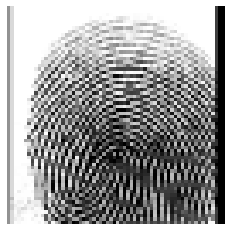

(32, 64, 64, 3)


In [5]:
for batch in dataset.take(1):
    images = batch

# Choose a random index from the batch
random_index = np.random.randint(0, batch_size)

# Select the image at the random index
random_image = images[random_index]

# Display the random image
plt.imshow(random_image.numpy().astype("uint8"))
plt.axis('off')
plt.show()

for x in dataset:
  print(x.numpy().shape)
  break

In [172]:
dataset = dataset.map(lambda x: (tf.image.rgb_to_grayscale(x),))


In [173]:
dataset = dataset.map(lambda x: (x / 127.5) - 1.0) #normalize input between -1 and 1 (instead of 0 and 1)

In [7]:
for x in dataset:
    print(x[0].numpy().shape)
    break


(64, 64, 1)


In [8]:
dataset_numpy = np.concatenate(list(dataset.as_numpy_iterator()), axis=0)

min_value = np.min(dataset_numpy)
max_value = np.max(dataset_numpy)

print("Minimum pixel value:", min_value)
print("Maximum pixel value:", max_value)


Minimum pixel value: -1.0
Maximum pixel value: 0.9998001


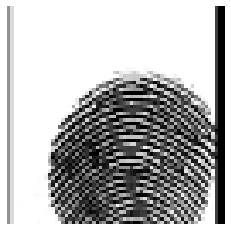

In [9]:
import matplotlib.pyplot as plt

for x in dataset:
    plt.axis("off")
    plt.imshow(((x[0].numpy() + 1) / 2).squeeze(), cmap='gray', vmin=0, vmax=1)
    break


In [174]:
class AddArtificialNoise(tf.keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super(AddArtificialNoise, self).__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=None):
        if training:
            # Generate artificial noise with the specified standard deviation
            noise = tf.random.normal(shape=tf.shape(inputs), mean=0.1, stddev=self.stddev)
            return inputs + noise
        return inputs

In [175]:
def build_discriminator():
    return tf.keras.Sequential(
        [
            tf.keras.Input(shape=(64, 64, 1)),
            AddArtificialNoise(stddev=0.1),  # Add artificial noise to the output of the first layer
            tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation="sigmoid"),
        ],
        name="discriminator",
    )
discriminator = build_discriminator()

In [176]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 add_artificial_noise_1 (Ad  (None, 64, 64, 1)         0         
 dArtificialNoise)                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1088      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         262272    
                                                     

In this notebook, two noises are defined, and in the main notebook, both of them are defined in one function.

In [177]:
class AddGaussianNoise(tf.keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super(AddGaussianNoise, self).__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=None):
        if training:
            # Generate noise with the specified standard deviation
            noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev)
            return inputs + noise
        return inputs

In [178]:
def build_generator(latent_dim = 128):
    return tf.keras.Sequential(
        [
            tf.keras.Input(shape=(latent_dim,)),
            tf.keras.layers.Dense(8 * 8 * 128),
            tf.keras.layers.Reshape((8, 8, 128)),
            tf.keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
            AddGaussianNoise(stddev=0.1),  # Add Gaussian noise 
            tf.keras.layers.LeakyReLU(alpha=0.2),
            AddGaussianNoise(stddev=0.1),  # Add Gaussian noise 
            tf.keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
            AddGaussianNoise(stddev=0.1),  # Add Gaussian noise 
            tf.keras.layers.LeakyReLU(alpha=0.2),
            AddGaussianNoise(stddev=0.1),  # Add Gaussian noise 
            tf.keras.layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
            AddGaussianNoise(stddev=0.1),  # Add Gaussian noise 
            tf.keras.layers.LeakyReLU(alpha=0.2),
            AddGaussianNoise(stddev=0.1),  # Add Gaussian noise 
            tf.keras.layers.Conv2D(1, kernel_size=5, padding="same", activation="tanh"),
        ],
        name="generator",
    )

generator = build_generator()

In [179]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)                                                      
                                                                 
 add_gaussian_noise_6 (AddG  (None, 16, 16, 128)       0         
 aussianNoise)                                                   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 add_gaussian_noise_7 (AddG  (None, 16, 16, 128)       0 

In [180]:
class GAN(tf.keras.Model):                                                  # subclassing `tf.keras.Model`
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")           # custom metrics
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):                   # `compile` required for `tf.keras.Model`
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):                                       # `train_step` required for `tf.keras.Model`
        batch_size = tf.shape(real_images)[0]

        # 1. TRAIN DISCRIMINATOR (2times more than the Generator)
        for _ in range(2):
            random_latent_vectors = tf.random.normal(                            # feed a batch of generated
              shape=(batch_size, self.latent_dim)
            )

            generated_images = self.generator(random_latent_vectors)
            combined_images = tf.concat([generated_images, real_images], axis=0) 
            
            labels = tf.concat( # (fake: -1, real: 1)
                [-tf.ones((batch_size, 1)), tf.ones((batch_size, 1))],
                axis=0
            )
            
            # (↓ label smoothing: inject randomness in the labels)
            labels += 0.05 * tf.random.uniform(tf.shape(labels))



            with tf.GradientTape() as tape:                                      # gradient logic:
                predictions = self.discriminator(combined_images)                # Discriminator predicts
                d_loss = self.loss_fn(labels, predictions)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)  # gradients to update
            self.d_optimizer.apply_gradients(                                    # our Discriminator
                zip(grads, self.discriminator.trainable_weights)
            )
            self.d_loss_metric.update_state(d_loss) # update loss

        # 2. TRAIN GENERATOR ------------------------------------------------------

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        # Normalize the latent points to lie on the surface of a sphere
        normalized_latent_points = tf.math.l2_normalize(random_latent_vectors, axis=1)
        
        misleading_labels = tf.ones((batch_size, 1)) # 1: real

        with tf.GradientTape() as tape:                                 # gradient logic:
            predictions = self.discriminator(                           # get predictions from Discriminator
                self.generator(normalized_latent_points)                   # from generated fake images
            )
            g_loss = self.loss_fn(misleading_labels, predictions)       # loss labels vs preds
        grads = tape.gradient(g_loss, self.generator.trainable_weights) # gradients to update
        self.g_optimizer.apply_gradients(                               # our Generator
            zip(grads, self.generator.trainable_weights)
        )
        self.g_loss_metric.update_state(g_loss) # update loss

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result()
        }

In [181]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128, show_every=1, save=True):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save = save
        self.show_every = show_every

    def on_epoch_end(self, epoch, logs=None):

        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images + 1) * 127.5  # Adjust scaling for image format
        generated_images.numpy()

        if self.save:
            for i in range(self.num_img):
                img = tf.keras.utils.array_to_img(generated_images[i])
                img.save(f'generated-grayscale-new/generated_img_{epoch:03d}_{i}.png')

        if epoch % self.show_every != 0:
            return
        
        _, axs = plt.subplots(2,2, figsize=(12,12)) # https://stackoverflow.com/a/54681765
        axs = axs.flatten()
        for i, (img, ax) in enumerate(zip(generated_images, axs)):
            img = tf.keras.utils.array_to_img(img)
            ax.axis('off')
            ax.imshow(img, cmap='gray')
        plt.show()
        


In [182]:
epochs = 50
latent_dim = 128

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

gan.compile(
    d_optimizer=tf.keras.optimizers.SGD(learning_rate=0.0002), 
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

In [183]:
reload = False # True to reload
generator_path = "generator_fingerptint_gan.h5"
discriminator_path = "discriminator_fingerptint_gan.h5"
if os.path.isfile(discriminator_path) and os.path.isfile(generator_path) and reload:
    gan.generator.load_weights(generator_path)
    gan.discriminator.load_weights(discriminator_path)

Epoch 1/50
188/188 [==============================] - ETA: 0s - d_loss: 0.5977 - g_loss: 0.5458

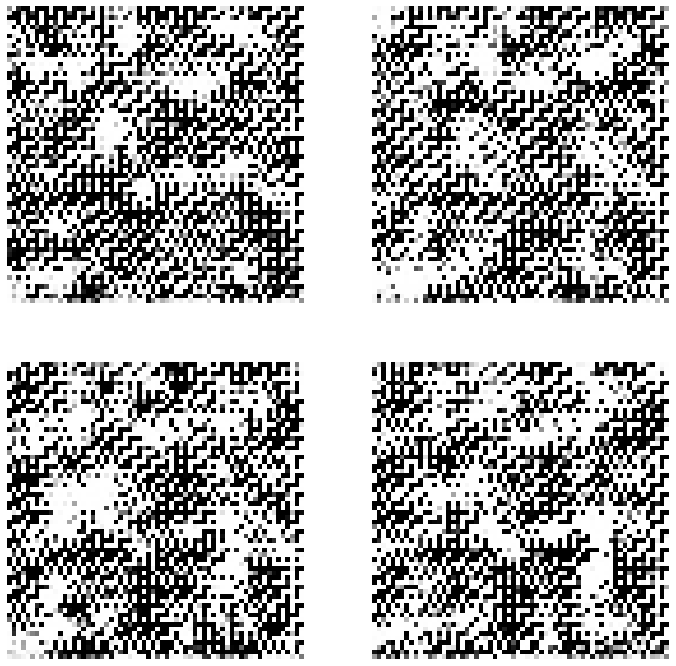

188/188 [==============================] - 216s 1s/step - d_loss: 0.5977 - g_loss: 0.5458
Epoch 2/50
188/188 [==============================] - ETA: 0s - d_loss: 0.2288 - g_loss: 0.8202

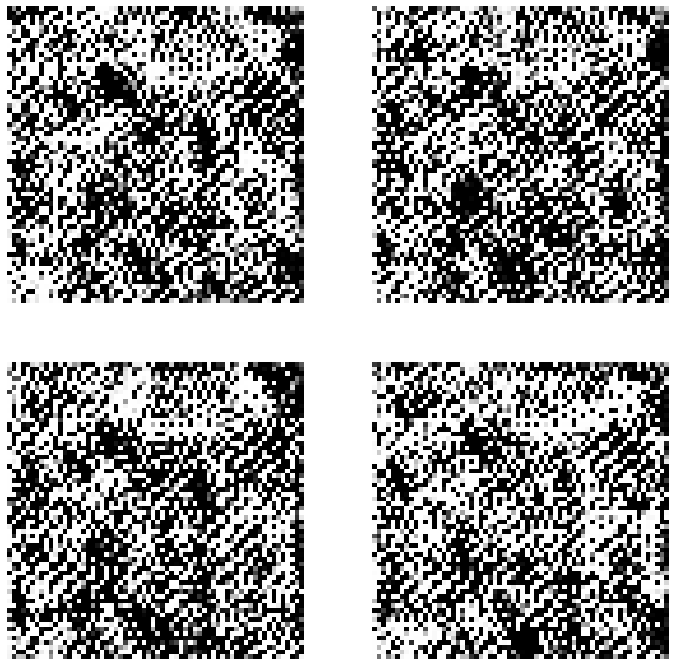

188/188 [==============================] - 210s 1s/step - d_loss: 0.2288 - g_loss: 0.8202
Epoch 3/50
188/188 [==============================] - ETA: 0s - d_loss: -0.0344 - g_loss: 1.6182

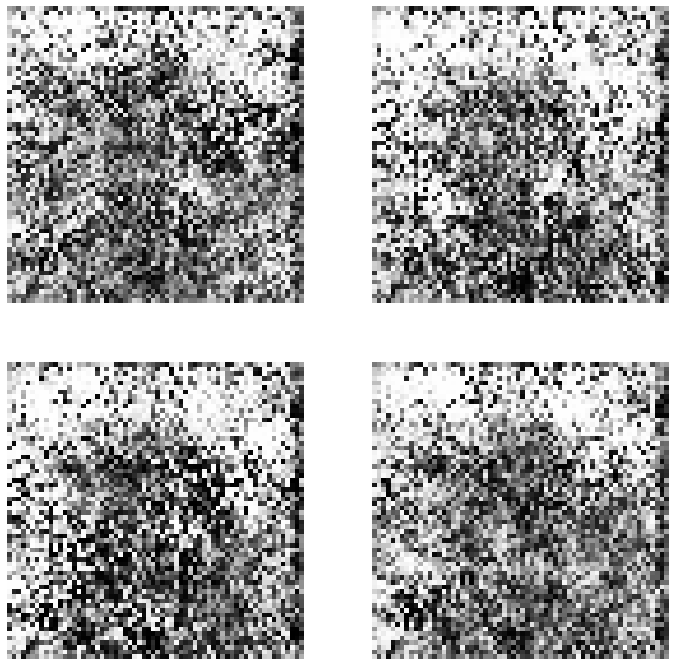

188/188 [==============================] - 210s 1s/step - d_loss: -0.0344 - g_loss: 1.6182
Epoch 4/50
188/188 [==============================] - ETA: 0s - d_loss: 0.4955 - g_loss: 1.1841

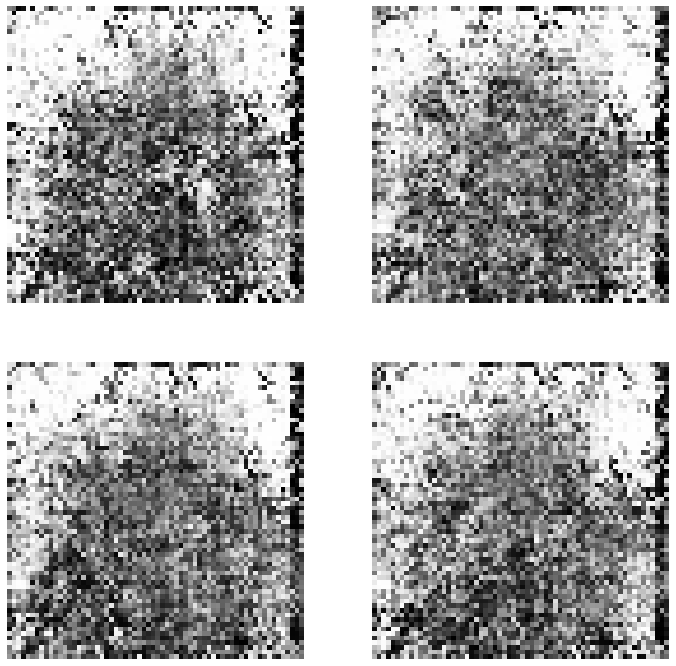

188/188 [==============================] - 209s 1s/step - d_loss: 0.4955 - g_loss: 1.1841
Epoch 5/50
188/188 [==============================] - ETA: 0s - d_loss: 0.5035 - g_loss: 1.5045

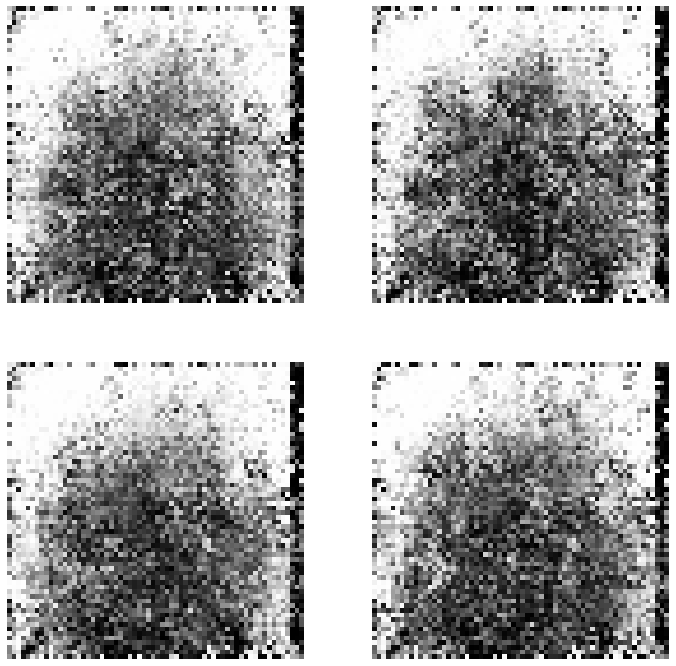

188/188 [==============================] - 209s 1s/step - d_loss: 0.5035 - g_loss: 1.5045
Epoch 6/50
188/188 [==============================] - ETA: 0s - d_loss: 0.5261 - g_loss: 1.8544

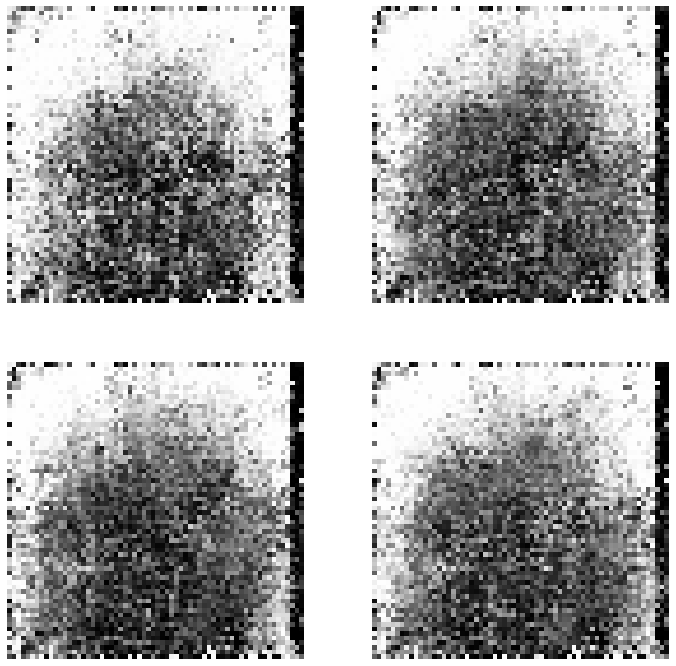

188/188 [==============================] - 210s 1s/step - d_loss: 0.5261 - g_loss: 1.8544
Epoch 7/50
188/188 [==============================] - ETA: 0s - d_loss: 0.4902 - g_loss: 2.0841

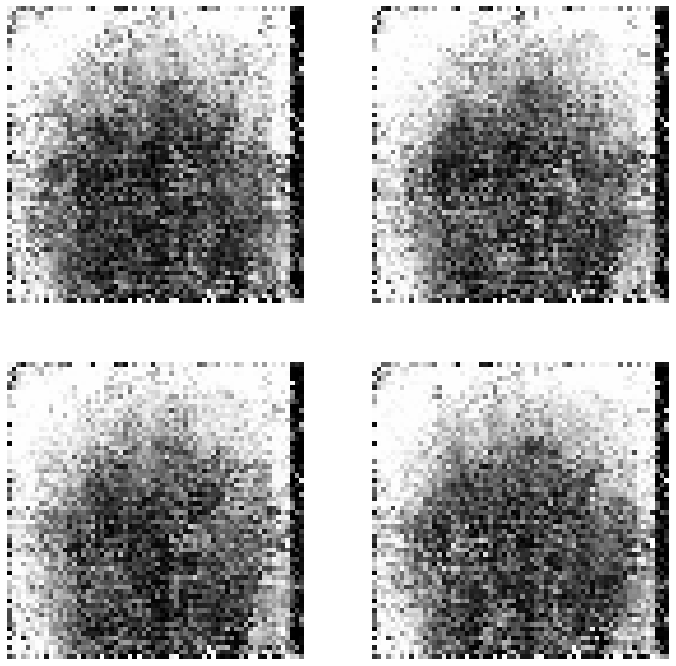

188/188 [==============================] - 209s 1s/step - d_loss: 0.4902 - g_loss: 2.0841
Epoch 8/50
188/188 [==============================] - ETA: 0s - d_loss: 0.4463 - g_loss: 2.2322

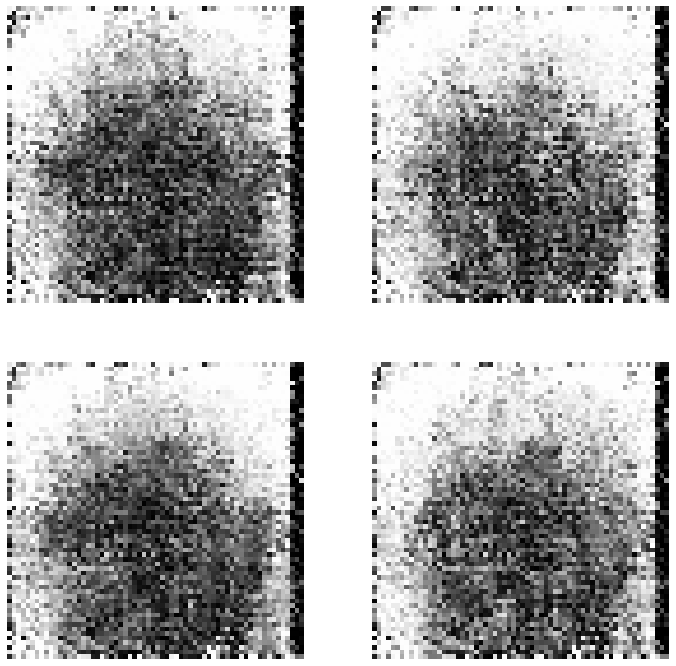

188/188 [==============================] - 210s 1s/step - d_loss: 0.4463 - g_loss: 2.2322
Epoch 9/50
188/188 [==============================] - ETA: 0s - d_loss: 0.4075 - g_loss: 2.3768

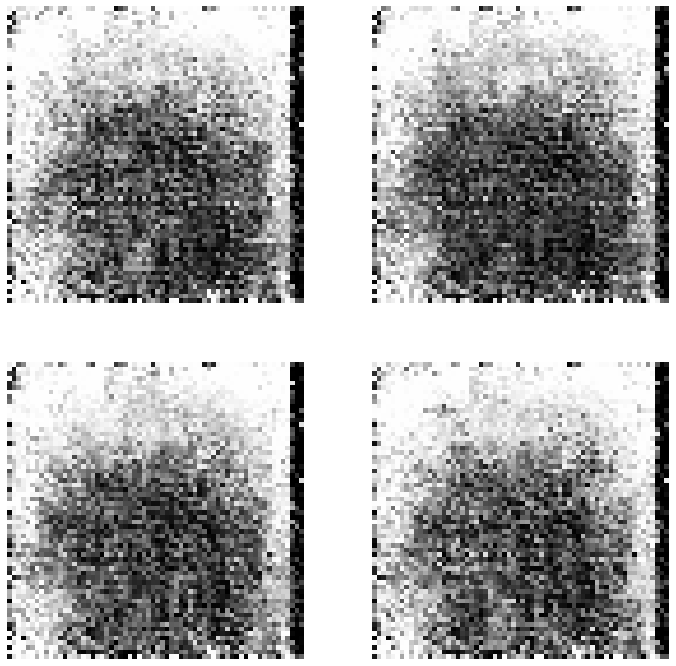

188/188 [==============================] - 209s 1s/step - d_loss: 0.4075 - g_loss: 2.3768
Epoch 10/50
188/188 [==============================] - ETA: 0s - d_loss: 0.3823 - g_loss: 2.4899

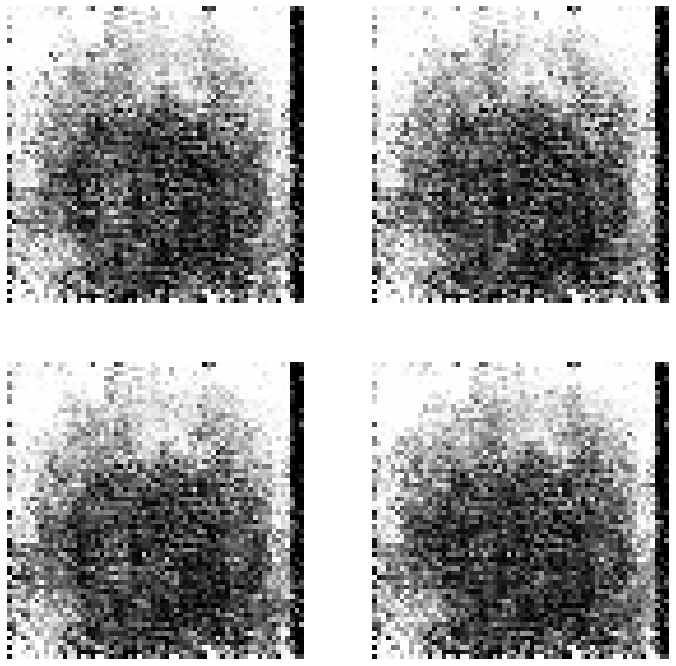

188/188 [==============================] - 211s 1s/step - d_loss: 0.3823 - g_loss: 2.4899
Epoch 11/50
188/188 [==============================] - ETA: 0s - d_loss: 0.3571 - g_loss: 2.5944

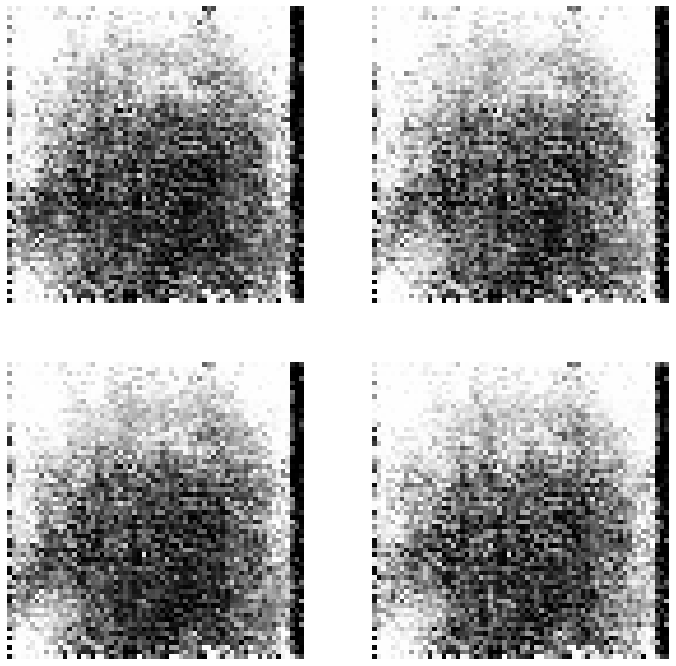

188/188 [==============================] - 210s 1s/step - d_loss: 0.3571 - g_loss: 2.5944
Epoch 12/50
188/188 [==============================] - ETA: 0s - d_loss: 0.3429 - g_loss: 2.6829

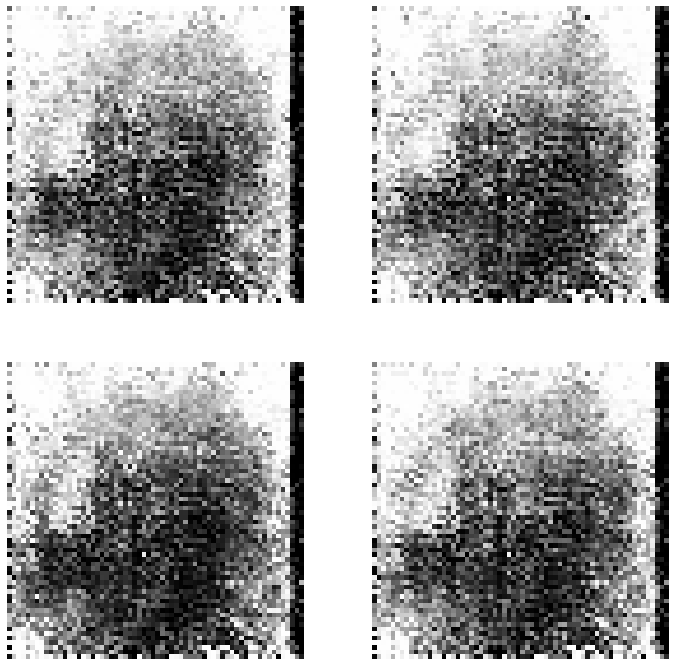

188/188 [==============================] - 210s 1s/step - d_loss: 0.3429 - g_loss: 2.6829
Epoch 13/50
188/188 [==============================] - ETA: 0s - d_loss: 0.3238 - g_loss: 2.7682

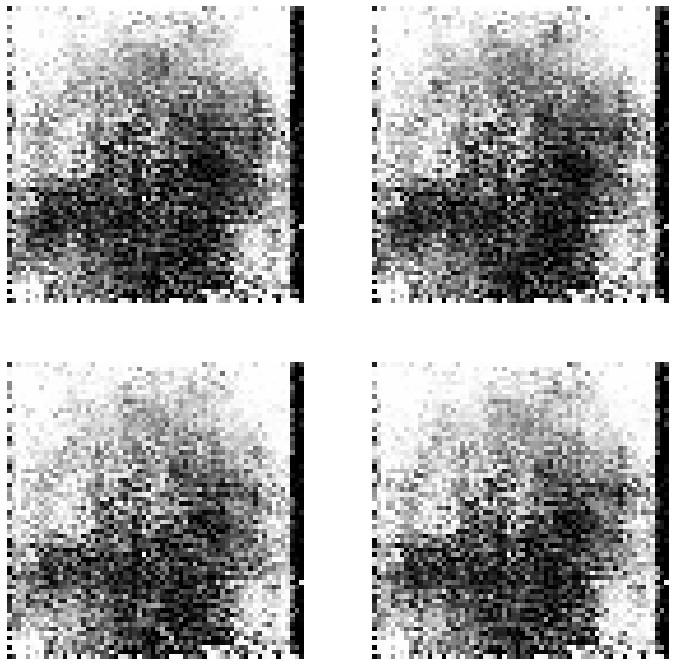

188/188 [==============================] - 209s 1s/step - d_loss: 0.3238 - g_loss: 2.7682
Epoch 14/50
188/188 [==============================] - ETA: 0s - d_loss: 0.3048 - g_loss: 2.8674

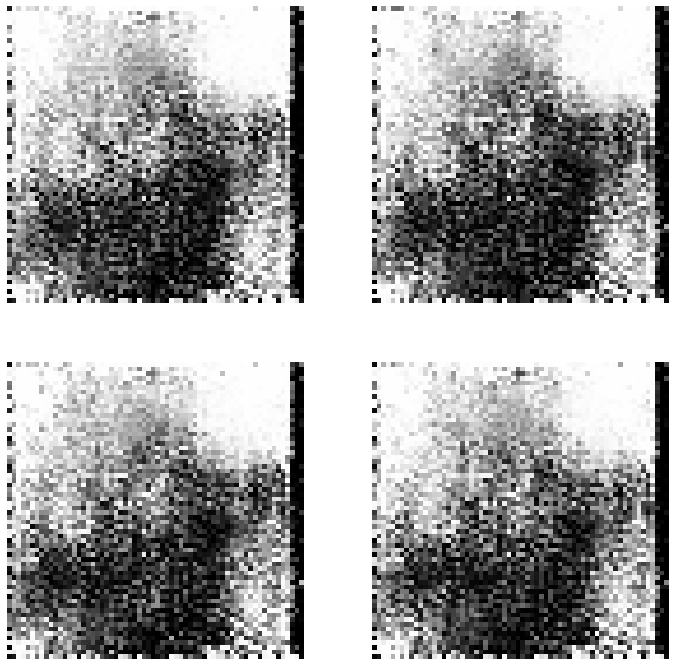

188/188 [==============================] - 211s 1s/step - d_loss: 0.3048 - g_loss: 2.8674
Epoch 15/50
188/188 [==============================] - ETA: 0s - d_loss: 0.2976 - g_loss: 2.9416

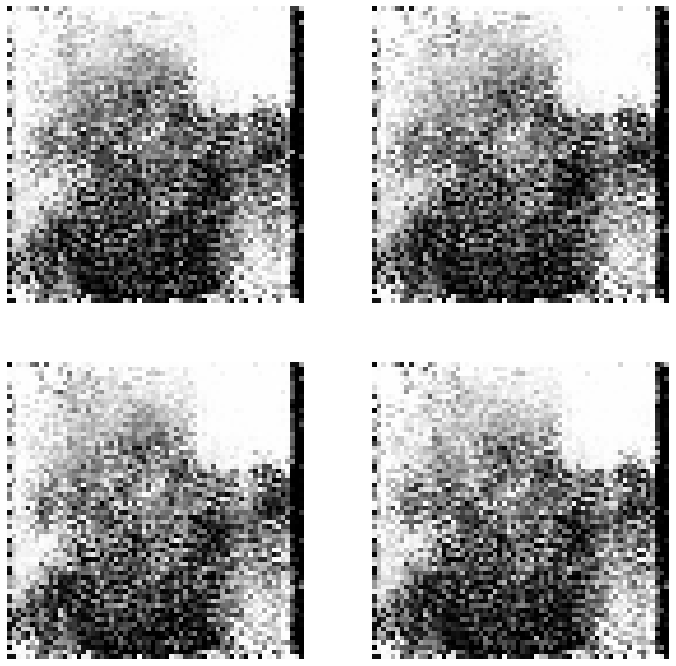

188/188 [==============================] - 215s 1s/step - d_loss: 0.2976 - g_loss: 2.9416
Epoch 16/50
188/188 [==============================] - ETA: 0s - d_loss: 0.2851 - g_loss: 2.9989

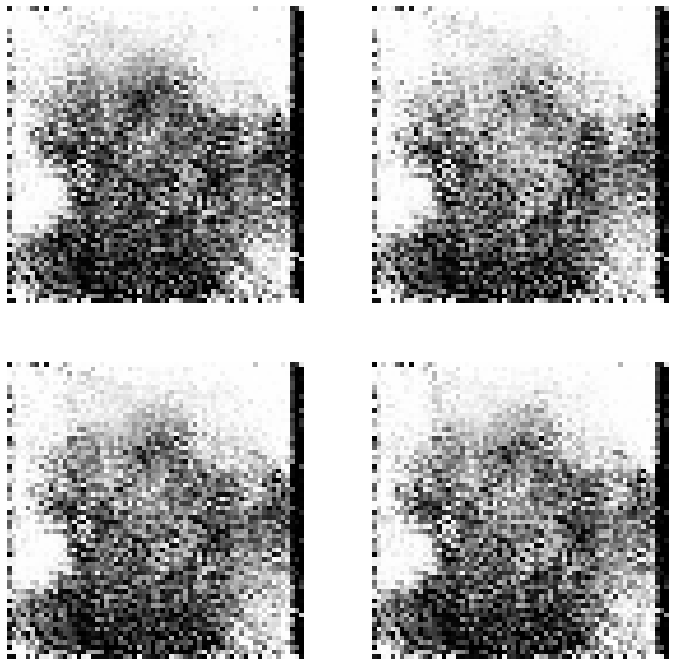

188/188 [==============================] - 212s 1s/step - d_loss: 0.2851 - g_loss: 2.9989
Epoch 17/50
188/188 [==============================] - ETA: 0s - d_loss: 0.2733 - g_loss: 3.0438

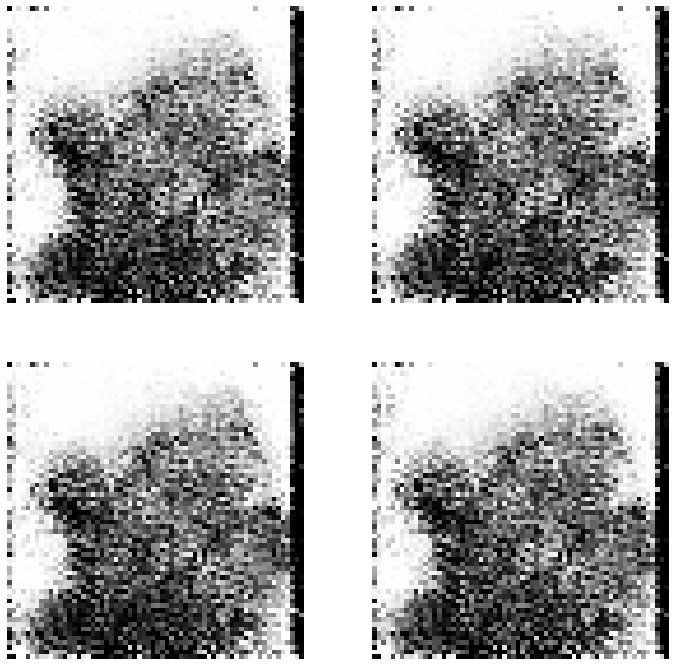

188/188 [==============================] - 214s 1s/step - d_loss: 0.2733 - g_loss: 3.0438
Epoch 18/50
188/188 [==============================] - ETA: 0s - d_loss: 0.2756 - g_loss: 3.0932

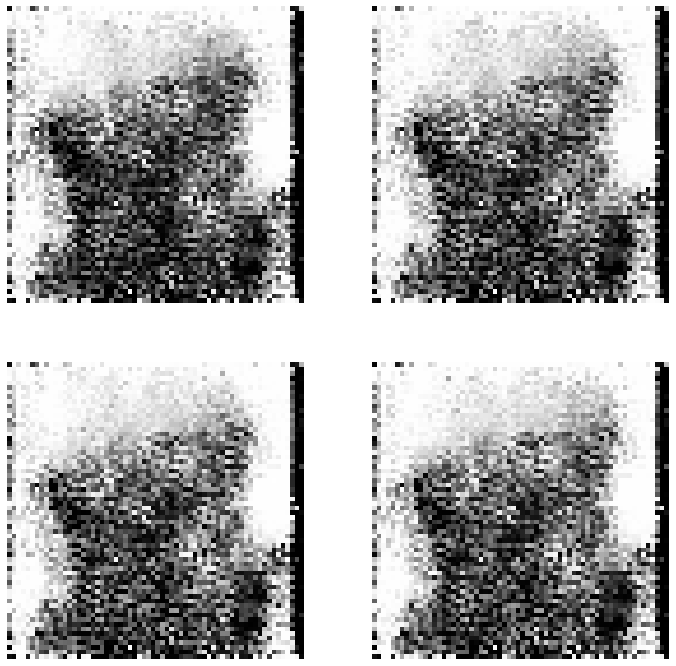

188/188 [==============================] - 213s 1s/step - d_loss: 0.2756 - g_loss: 3.0932
Epoch 19/50
188/188 [==============================] - ETA: 0s - d_loss: 0.2669 - g_loss: 3.1391

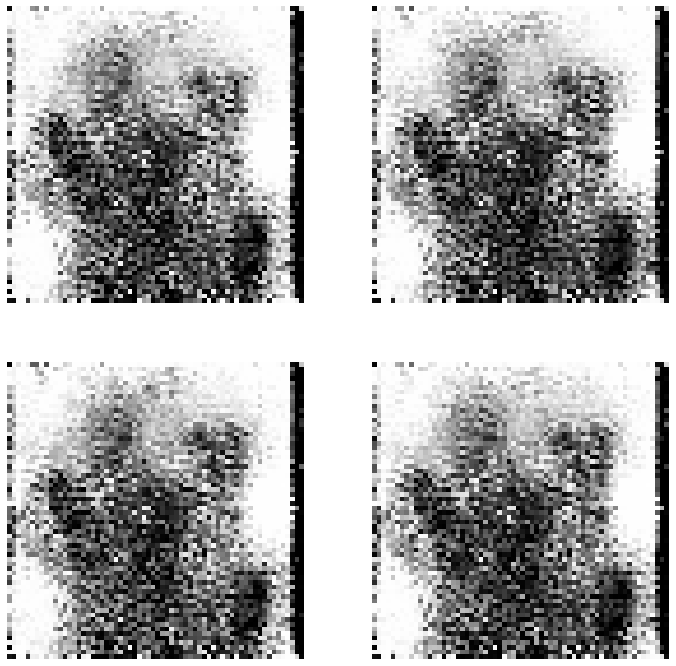

188/188 [==============================] - 210s 1s/step - d_loss: 0.2669 - g_loss: 3.1391
Epoch 20/50
188/188 [==============================] - ETA: 0s - d_loss: 0.2692 - g_loss: 3.1568

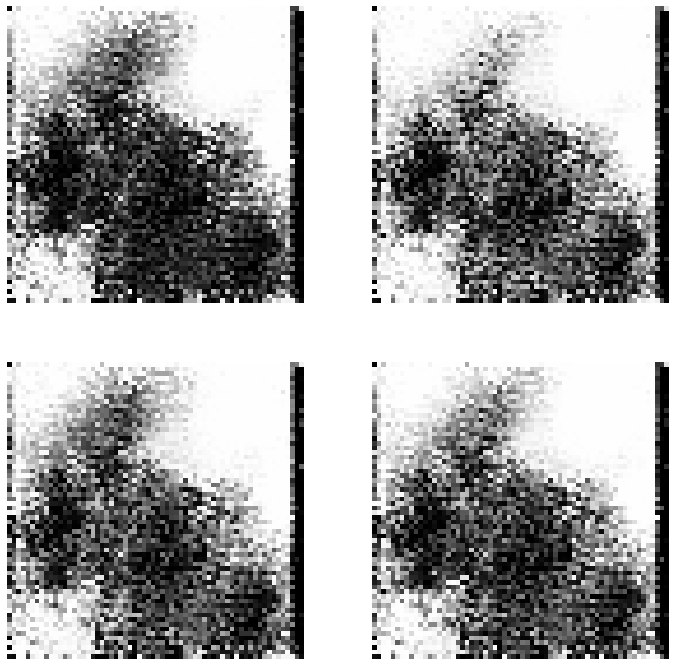

188/188 [==============================] - 211s 1s/step - d_loss: 0.2692 - g_loss: 3.1568
Epoch 21/50
188/188 [==============================] - ETA: 0s - d_loss: 0.2531 - g_loss: 3.2041

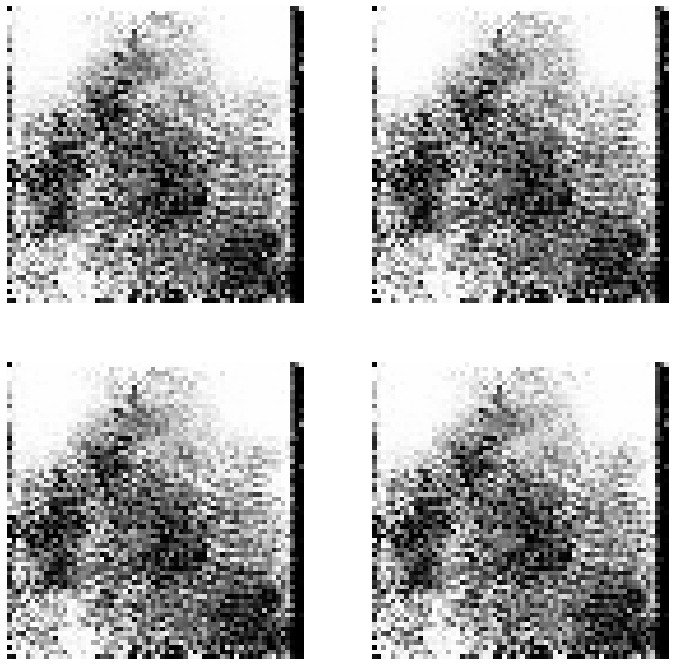

188/188 [==============================] - 211s 1s/step - d_loss: 0.2531 - g_loss: 3.2041
Epoch 22/50
188/188 [==============================] - ETA: 0s - d_loss: 0.2687 - g_loss: 3.1435

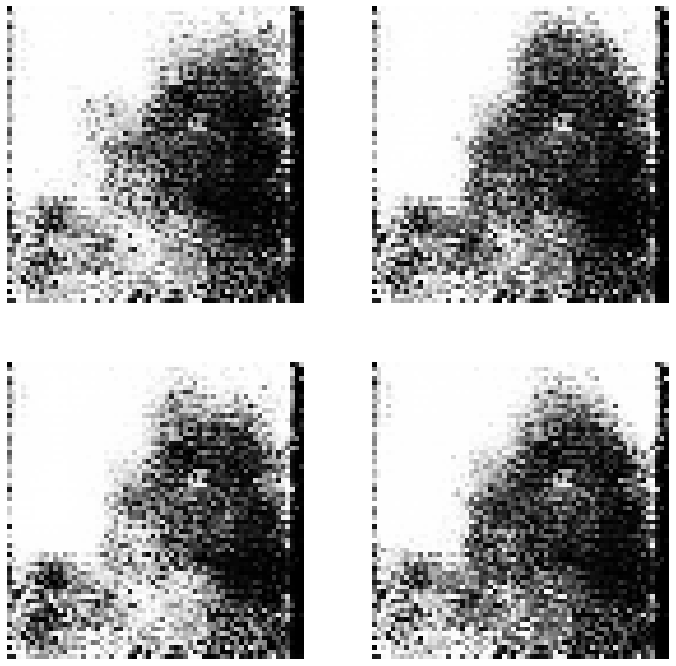

188/188 [==============================] - 210s 1s/step - d_loss: 0.2687 - g_loss: 3.1435
Epoch 23/50
188/188 [==============================] - ETA: 0s - d_loss: 0.2419 - g_loss: 3.1855

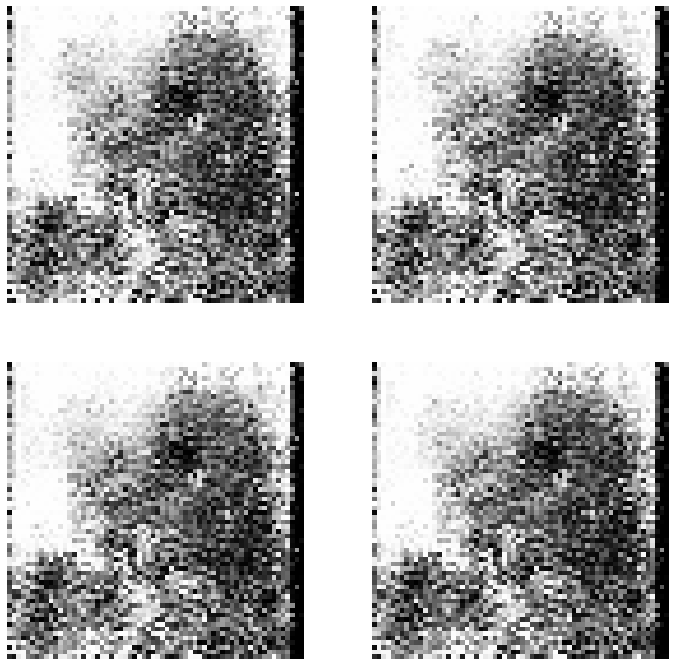

188/188 [==============================] - 211s 1s/step - d_loss: 0.2419 - g_loss: 3.1855
Epoch 24/50
188/188 [==============================] - ETA: 0s - d_loss: 0.2311 - g_loss: 3.2011

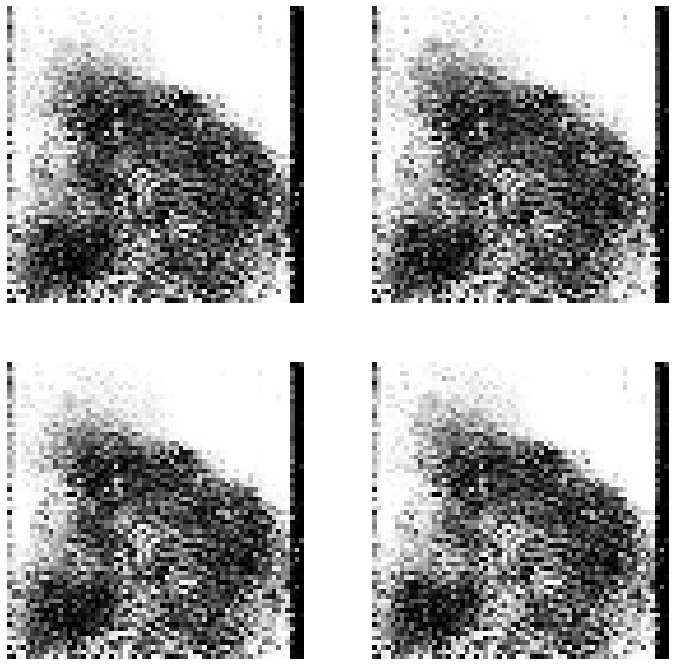

188/188 [==============================] - 212s 1s/step - d_loss: 0.2311 - g_loss: 3.2011
Epoch 25/50
188/188 [==============================] - ETA: 0s - d_loss: 0.2527 - g_loss: 3.2452

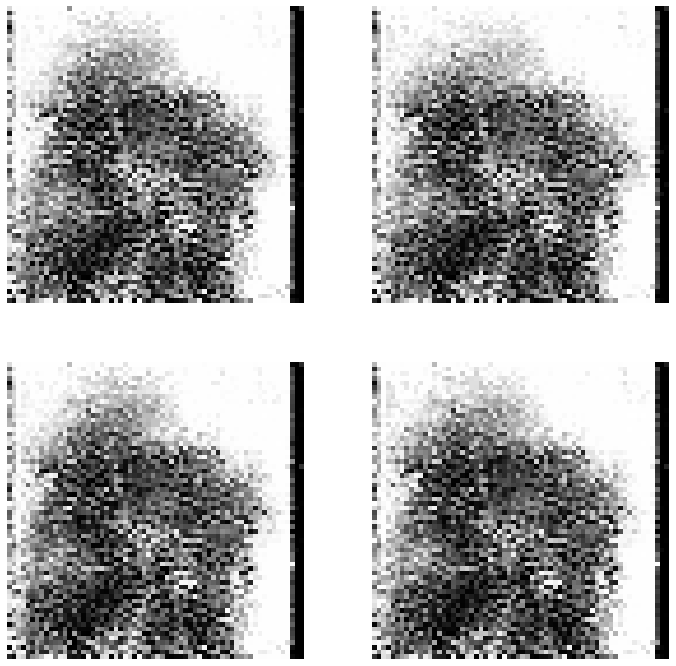

188/188 [==============================] - 211s 1s/step - d_loss: 0.2527 - g_loss: 3.2452
Epoch 26/50
188/188 [==============================] - ETA: 0s - d_loss: 0.2327 - g_loss: 3.2722

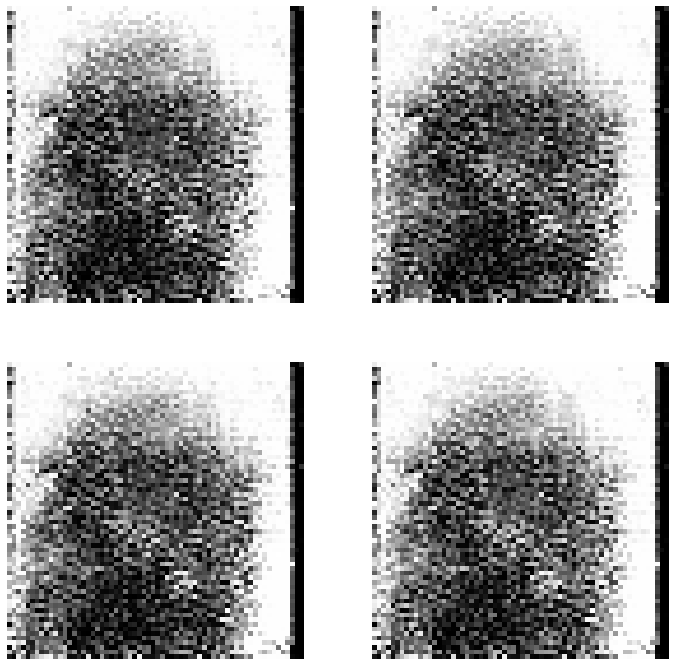

188/188 [==============================] - 209s 1s/step - d_loss: 0.2327 - g_loss: 3.2722
Epoch 27/50
188/188 [==============================] - ETA: 0s - d_loss: 0.2192 - g_loss: 3.3005

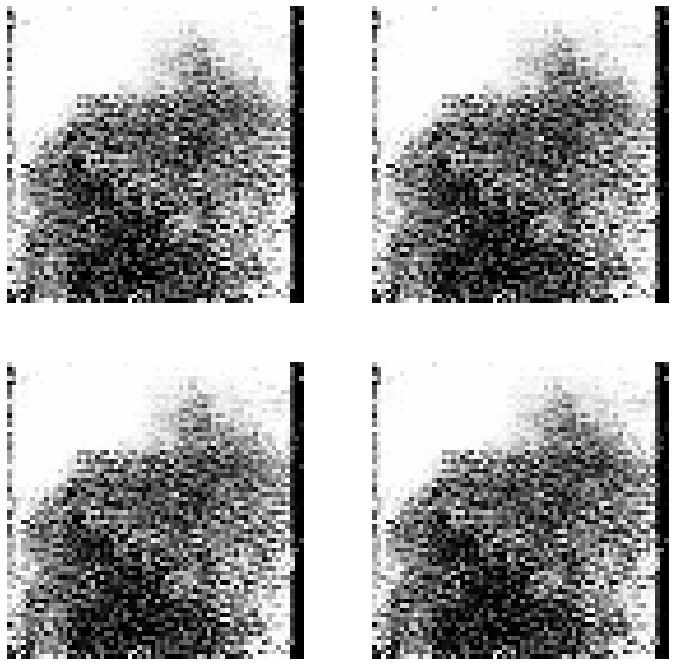

188/188 [==============================] - 211s 1s/step - d_loss: 0.2192 - g_loss: 3.3005
Epoch 28/50
188/188 [==============================] - ETA: 0s - d_loss: 0.2247 - g_loss: 3.2918

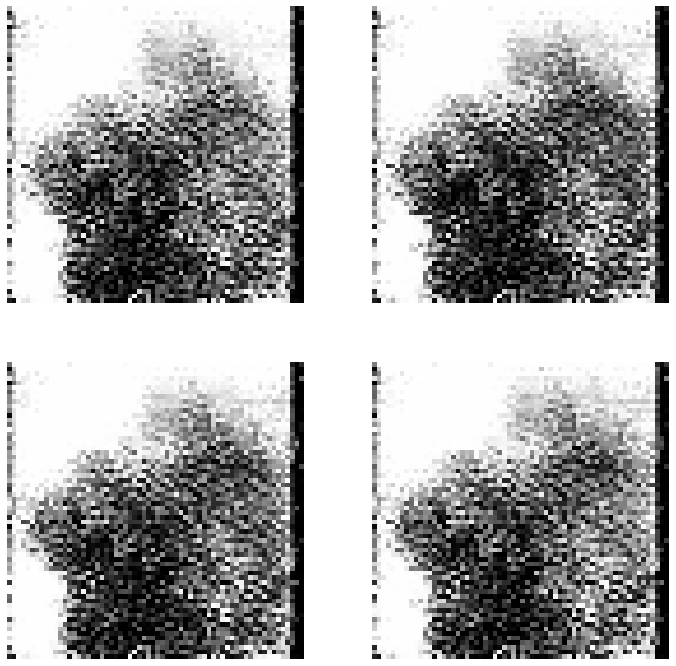

188/188 [==============================] - 210s 1s/step - d_loss: 0.2247 - g_loss: 3.2918
Epoch 29/50
188/188 [==============================] - ETA: 0s - d_loss: 0.2172 - g_loss: 3.3216

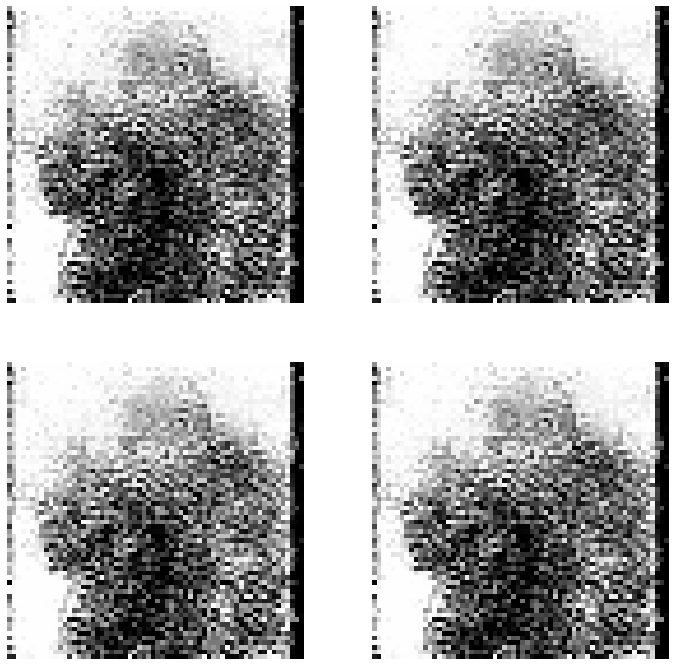

188/188 [==============================] - 210s 1s/step - d_loss: 0.2172 - g_loss: 3.3216
Epoch 30/50
188/188 [==============================] - ETA: 0s - d_loss: 0.2086 - g_loss: 3.3324

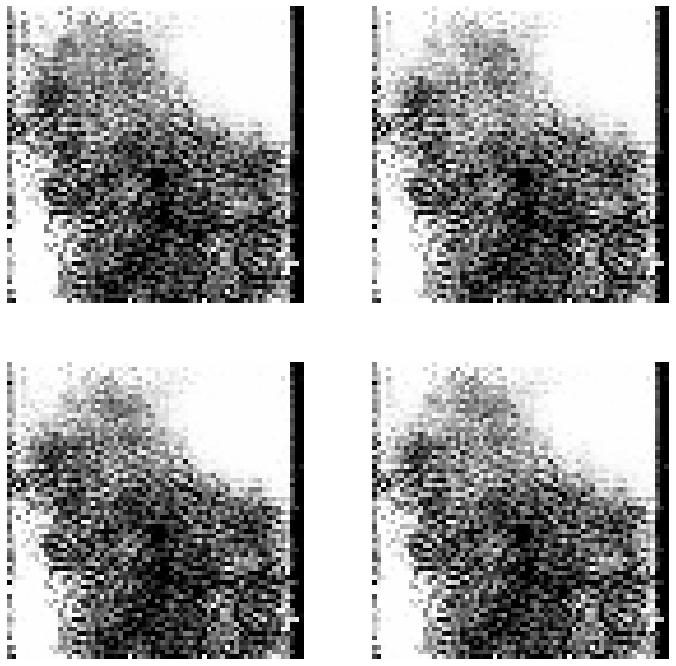

188/188 [==============================] - 210s 1s/step - d_loss: 0.2086 - g_loss: 3.3324
Epoch 31/50
188/188 [==============================] - ETA: 0s - d_loss: 0.1960 - g_loss: 3.3236

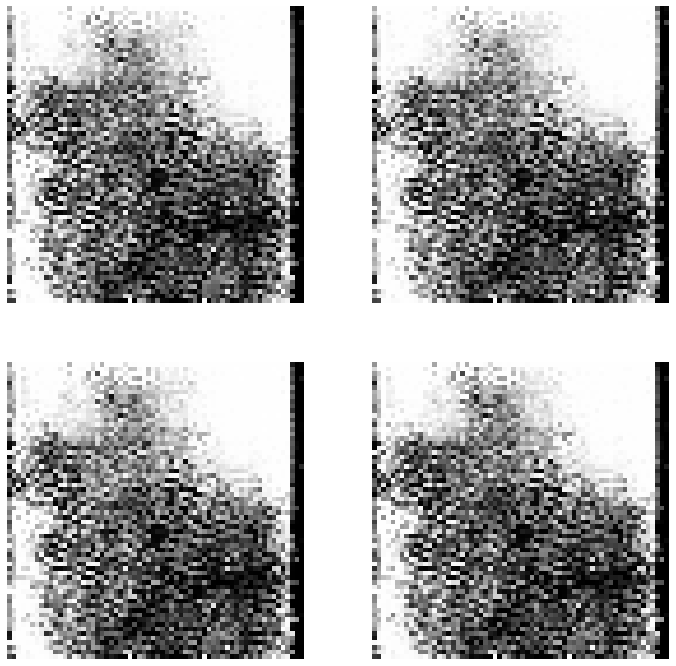

188/188 [==============================] - 210s 1s/step - d_loss: 0.1960 - g_loss: 3.3236
Epoch 32/50
188/188 [==============================] - ETA: 0s - d_loss: 0.1981 - g_loss: 3.3399

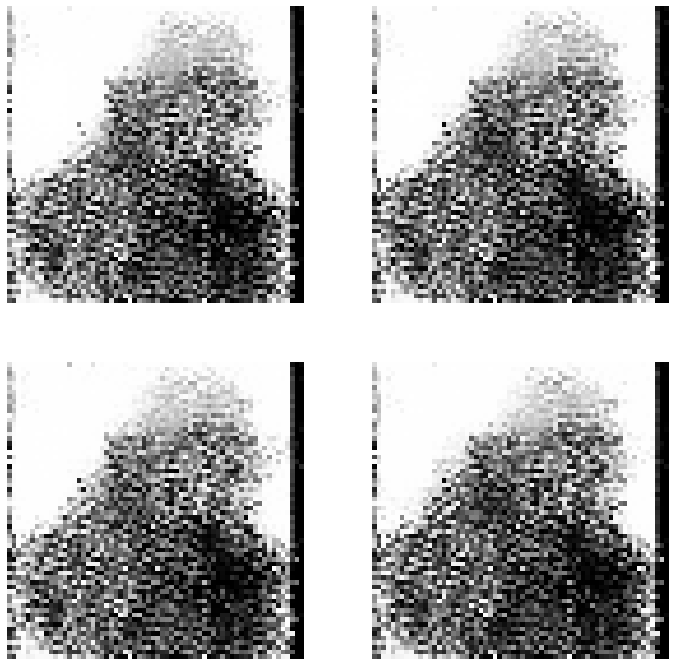

188/188 [==============================] - 213s 1s/step - d_loss: 0.1981 - g_loss: 3.3399
Epoch 33/50
188/188 [==============================] - ETA: 0s - d_loss: 0.2025 - g_loss: 3.3588

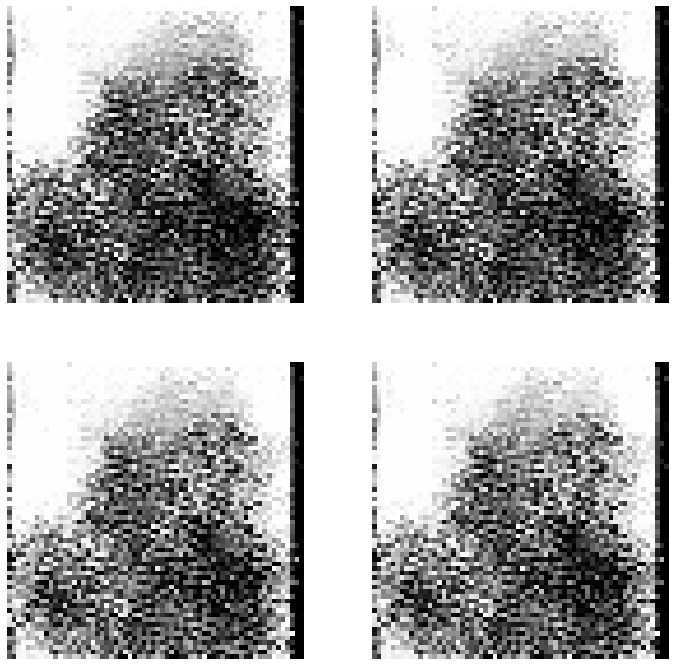

188/188 [==============================] - 212s 1s/step - d_loss: 0.2025 - g_loss: 3.3588
Epoch 34/50
188/188 [==============================] - ETA: 0s - d_loss: 0.1893 - g_loss: 3.3794

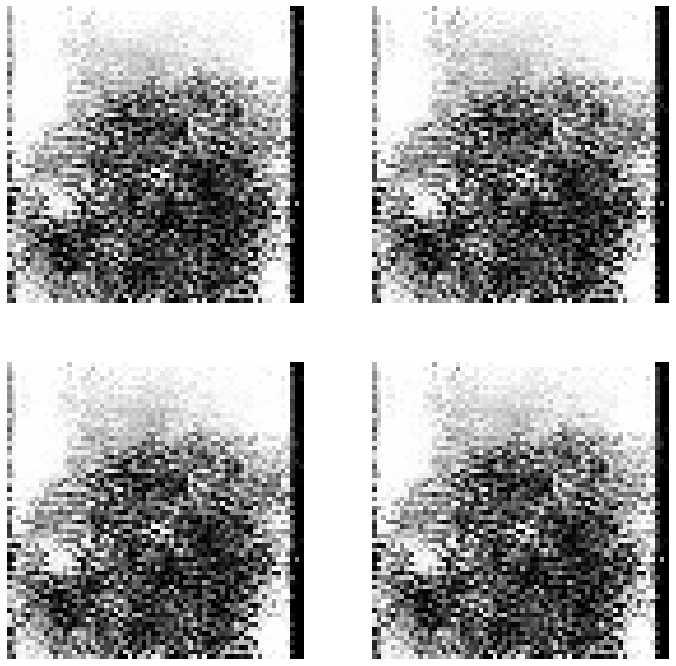

188/188 [==============================] - 215s 1s/step - d_loss: 0.1893 - g_loss: 3.3794
Epoch 35/50
188/188 [==============================] - ETA: 0s - d_loss: 0.2082 - g_loss: 3.3733

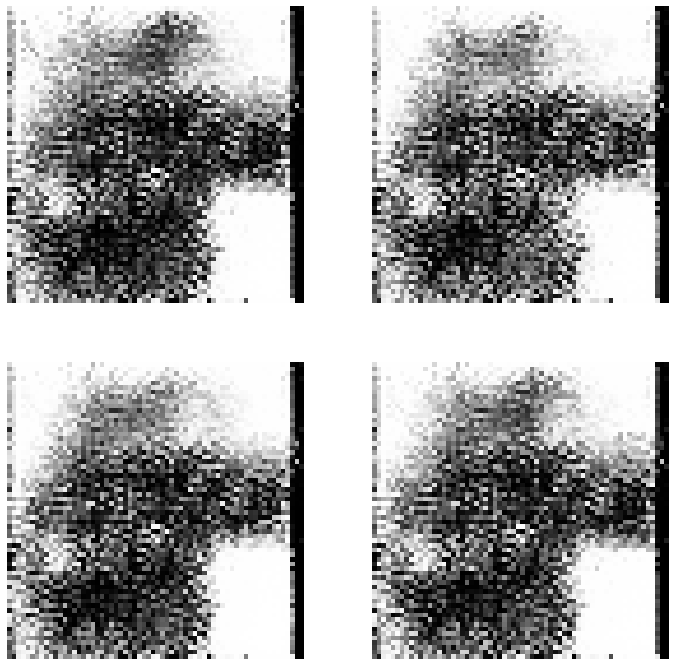

188/188 [==============================] - 212s 1s/step - d_loss: 0.2082 - g_loss: 3.3733
Epoch 36/50
188/188 [==============================] - ETA: 0s - d_loss: 0.1954 - g_loss: 3.3660

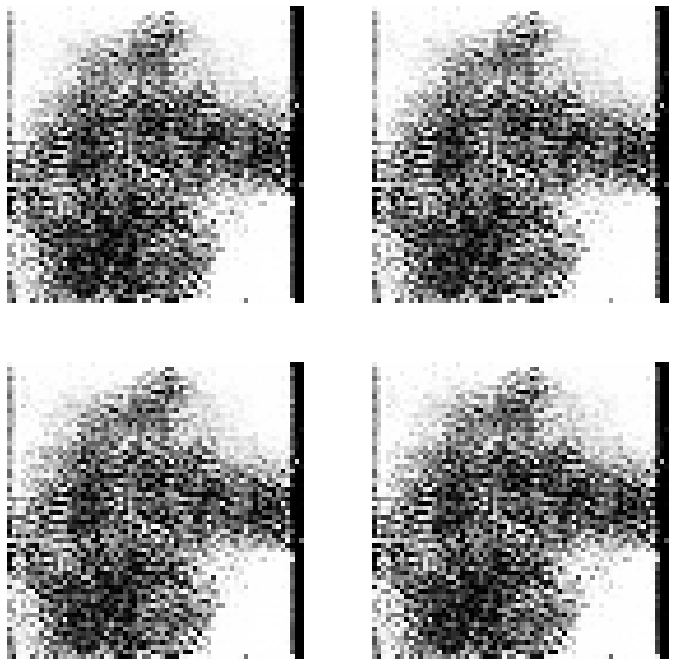

188/188 [==============================] - 210s 1s/step - d_loss: 0.1954 - g_loss: 3.3660
Epoch 37/50
188/188 [==============================] - ETA: 0s - d_loss: 0.1833 - g_loss: 3.4100

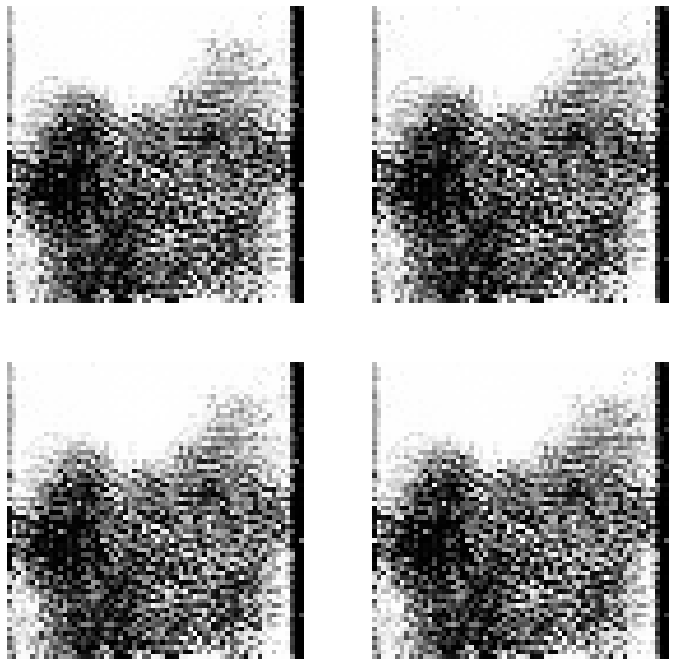

188/188 [==============================] - 211s 1s/step - d_loss: 0.1833 - g_loss: 3.4100
Epoch 38/50
188/188 [==============================] - ETA: 0s - d_loss: 0.1959 - g_loss: 3.4259

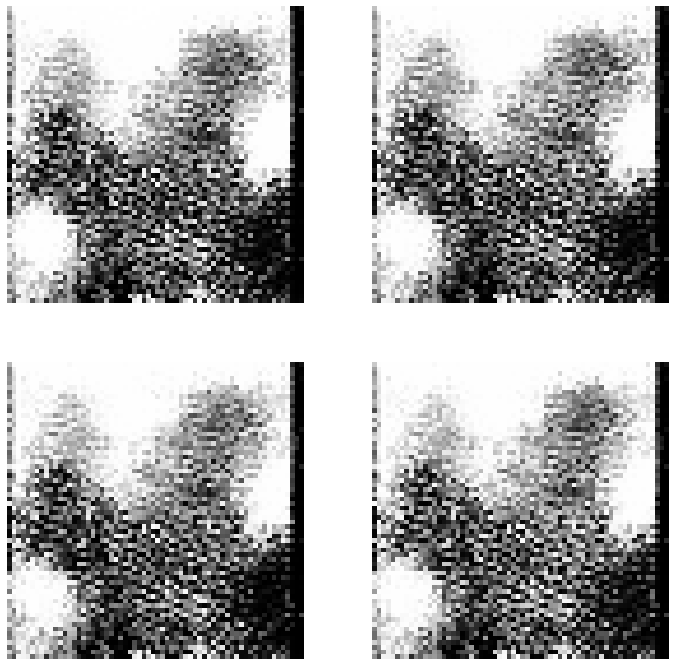

188/188 [==============================] - 211s 1s/step - d_loss: 0.1959 - g_loss: 3.4259
Epoch 39/50
188/188 [==============================] - ETA: 0s - d_loss: 0.1948 - g_loss: 3.4149

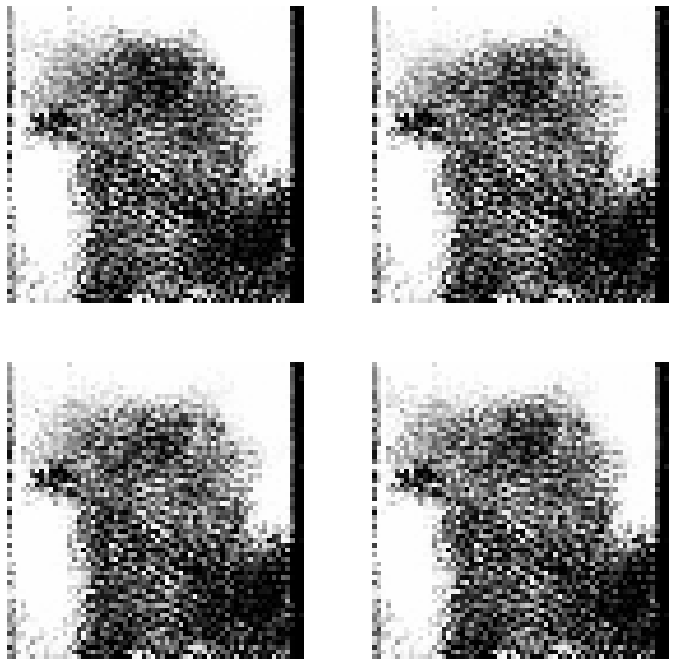

188/188 [==============================] - 211s 1s/step - d_loss: 0.1948 - g_loss: 3.4149
Epoch 40/50
188/188 [==============================] - ETA: 0s - d_loss: 0.1790 - g_loss: 3.4644

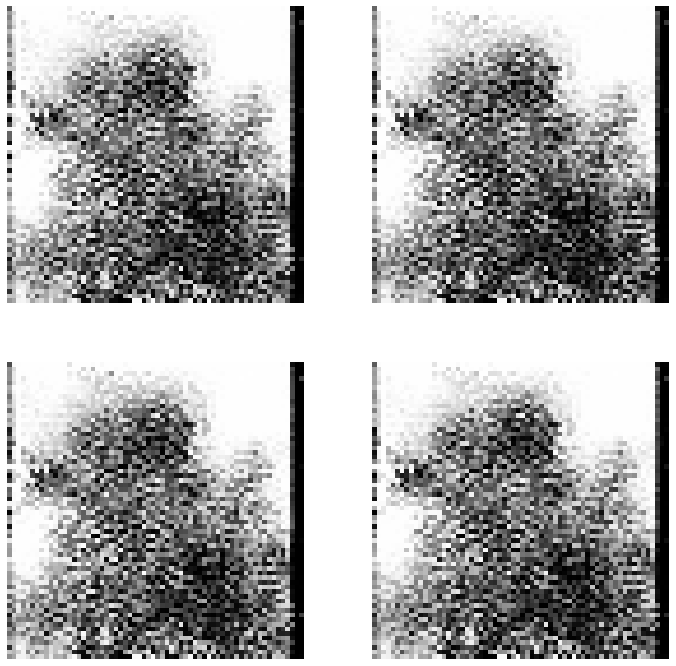

188/188 [==============================] - 210s 1s/step - d_loss: 0.1790 - g_loss: 3.4644
Epoch 41/50
188/188 [==============================] - ETA: 0s - d_loss: 0.1881 - g_loss: 3.4396

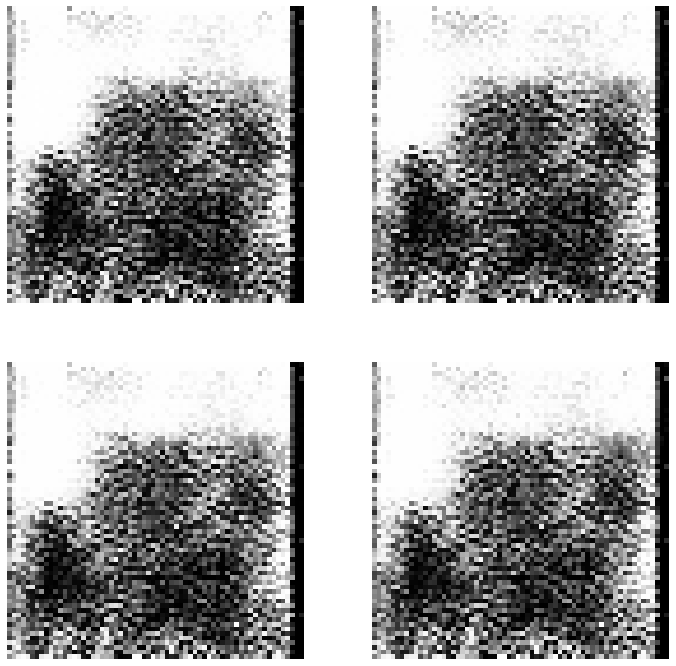

188/188 [==============================] - 211s 1s/step - d_loss: 0.1881 - g_loss: 3.4396
Epoch 42/50
188/188 [==============================] - ETA: 0s - d_loss: 0.1952 - g_loss: 3.4469

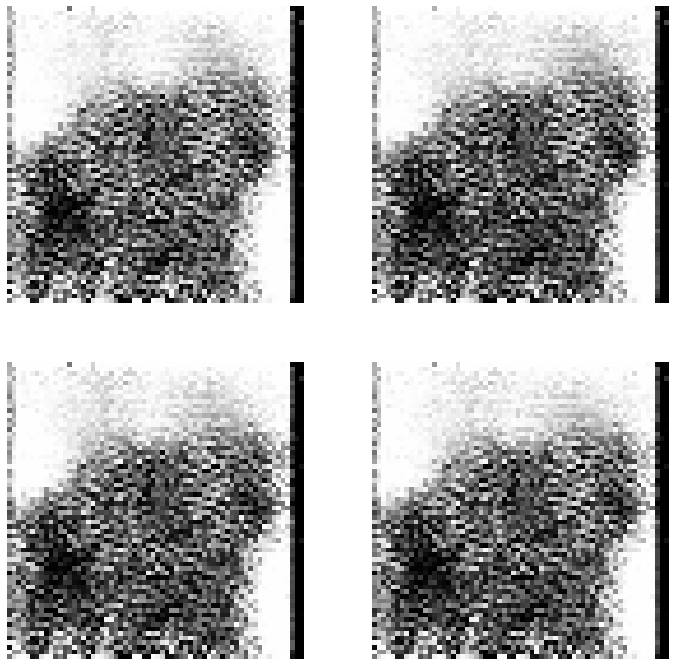

188/188 [==============================] - 212s 1s/step - d_loss: 0.1952 - g_loss: 3.4469
Epoch 43/50
188/188 [==============================] - ETA: 0s - d_loss: 0.1795 - g_loss: 3.4265

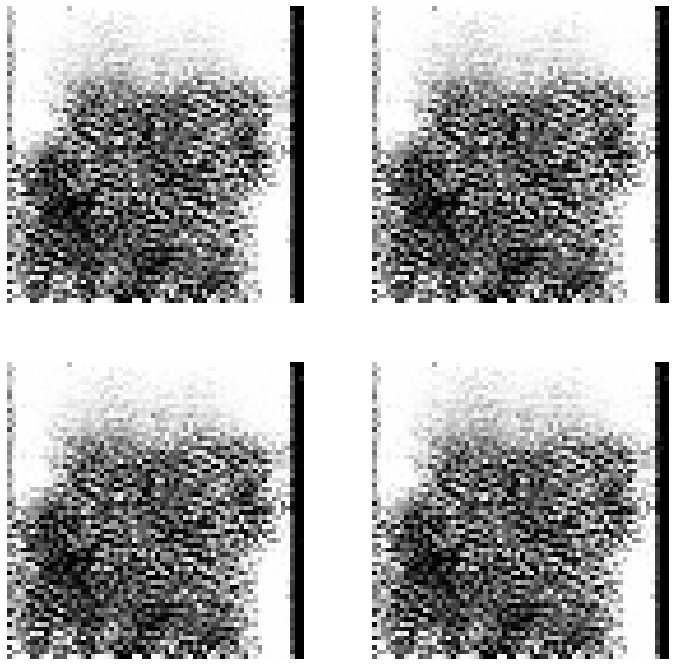

188/188 [==============================] - 211s 1s/step - d_loss: 0.1795 - g_loss: 3.4265
Epoch 44/50
188/188 [==============================] - ETA: 0s - d_loss: 0.1704 - g_loss: 3.4458

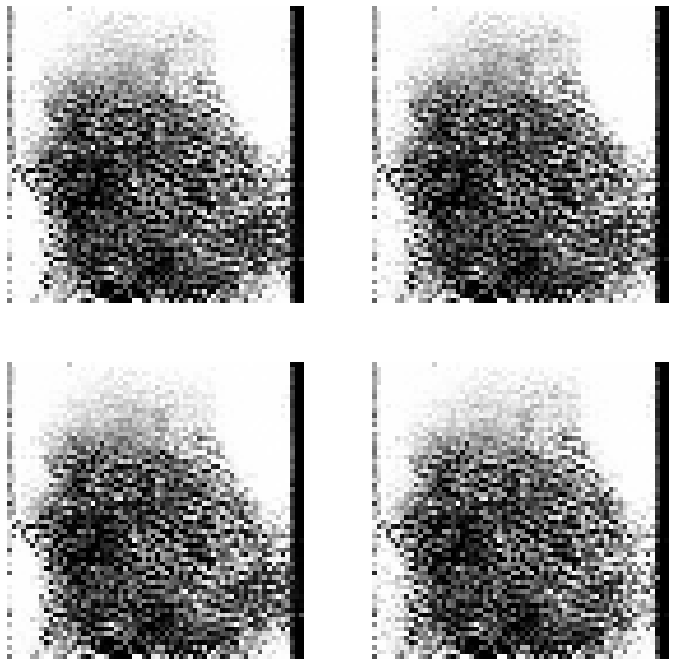

188/188 [==============================] - 210s 1s/step - d_loss: 0.1704 - g_loss: 3.4458
Epoch 45/50
188/188 [==============================] - ETA: 0s - d_loss: 0.1826 - g_loss: 3.4317

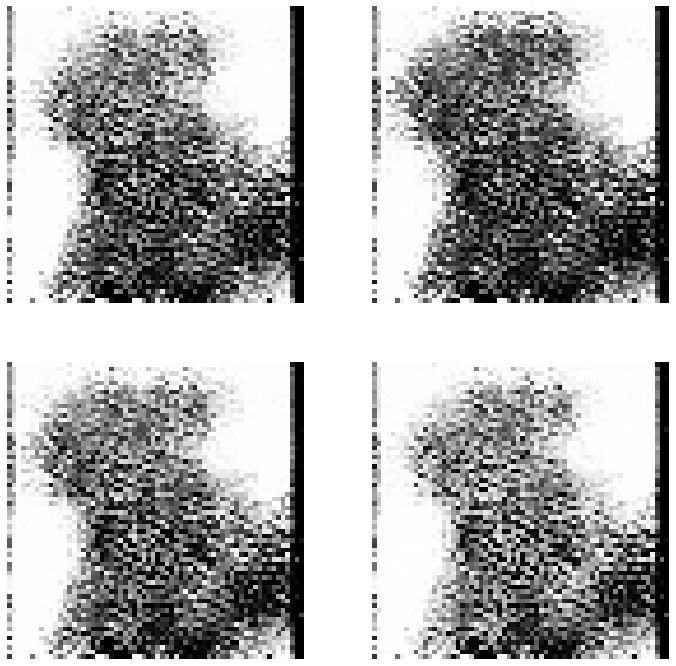

188/188 [==============================] - 210s 1s/step - d_loss: 0.1826 - g_loss: 3.4317
Epoch 46/50
188/188 [==============================] - ETA: 0s - d_loss: 0.1618 - g_loss: 3.4512

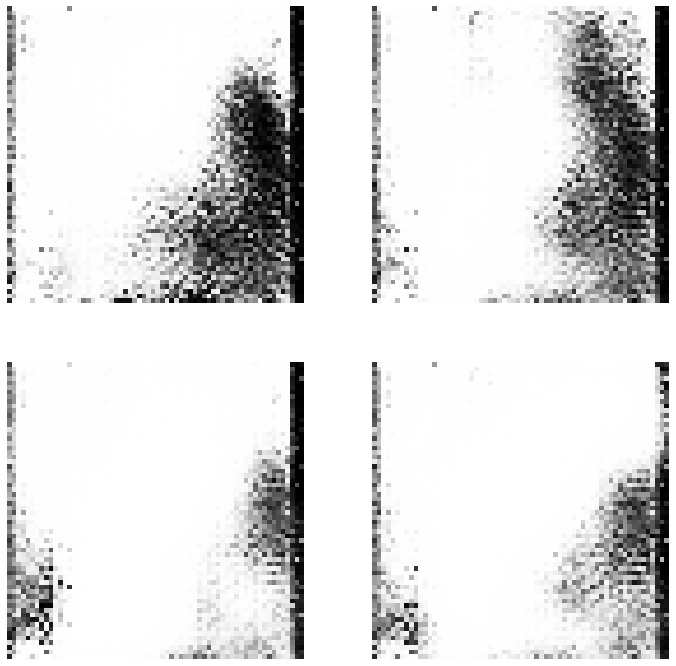

188/188 [==============================] - 209s 1s/step - d_loss: 0.1618 - g_loss: 3.4512
Epoch 47/50
188/188 [==============================] - ETA: 0s - d_loss: 0.1635 - g_loss: 3.4396

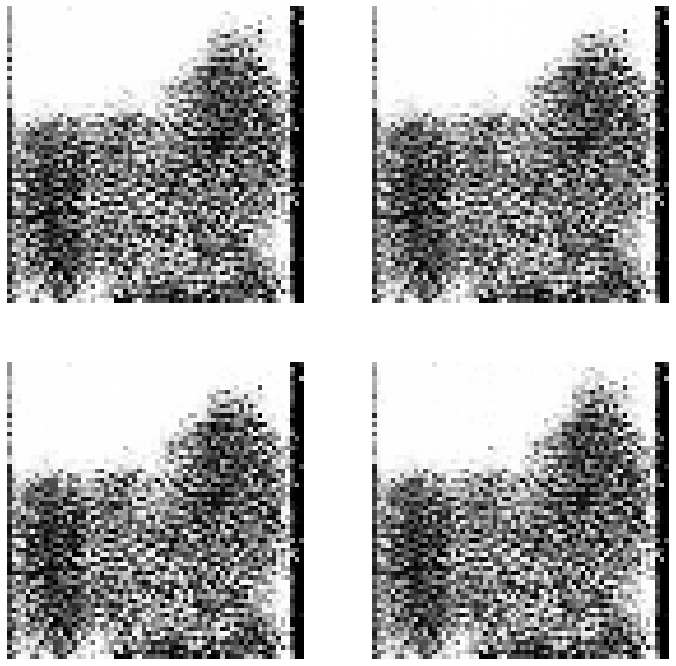

188/188 [==============================] - 209s 1s/step - d_loss: 0.1635 - g_loss: 3.4396
Epoch 48/50
188/188 [==============================] - ETA: 0s - d_loss: 0.1691 - g_loss: 3.4104

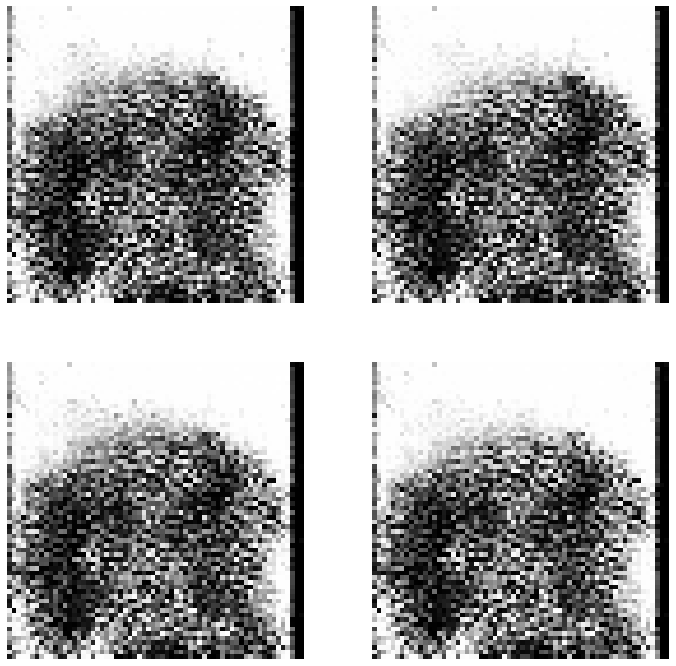

188/188 [==============================] - 211s 1s/step - d_loss: 0.1691 - g_loss: 3.4104
Epoch 49/50
188/188 [==============================] - ETA: 0s - d_loss: 0.1709 - g_loss: 3.4949

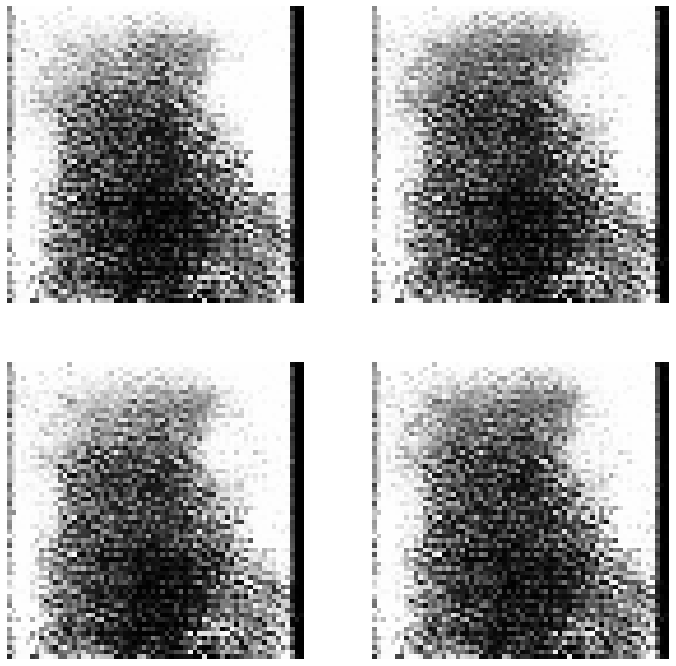

188/188 [==============================] - 213s 1s/step - d_loss: 0.1709 - g_loss: 3.4949
Epoch 50/50
188/188 [==============================] - ETA: 0s - d_loss: 0.1718 - g_loss: 3.4948

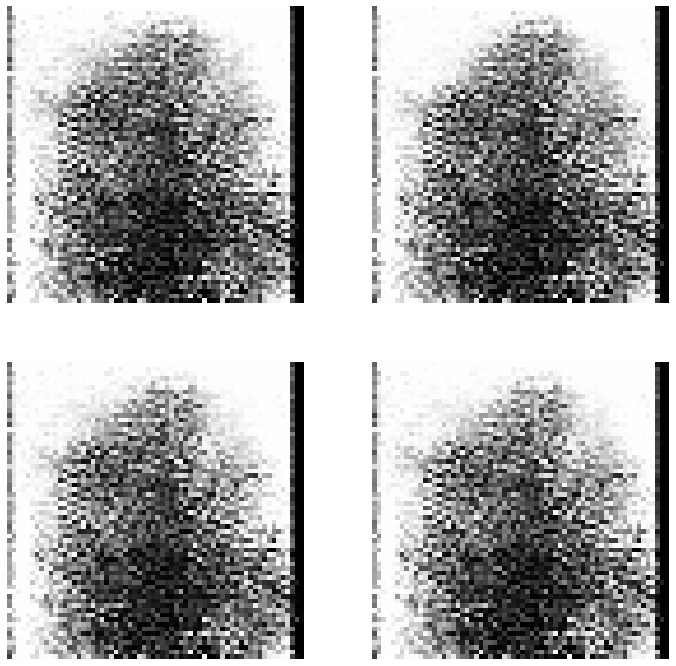

188/188 [==============================] - 214s 1s/step - d_loss: 0.1718 - g_loss: 3.4948


In [20]:
gan.fit(
    dataset, epochs=epochs, callbacks=[
        GANMonitor(num_img=4, latent_dim=latent_dim, show_every=1, save=True),
    ],
)

Save the weights for the discriminator and generator.

In [21]:
discriminator.save_weights(discriminator_path)          # SAVE
generator.save_weights(generator_path)

# ADD batch normalisation, Train generator twice, decrease the learning rate
In the next section, I will add batch normalization to my discriminator and generator, lower the learning rate and train the generator twice.

In [196]:
tf.keras.backend.clear_session()

In [197]:
del discriminator, generator, gan

In [198]:
def build_discriminator():
    return tf.keras.Sequential(
        [
            tf.keras.Input(shape=(64, 64, 1)),
            AddArtificialNoise(stddev=0.1),  # Add noise to the output of the first layer
            tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.BatchNormalization(),  #batch normalization
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.BatchNormalization(),  # batch normalization
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.BatchNormalization(),  # batch normalization
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation="sigmoid"),
        ],
        name="discriminator",
    )
discriminator = build_discriminator()

In [199]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 add_artificial_noise (AddA  (None, 64, 64, 1)         0         
 rtificialNoise)                                                 
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1088      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)     

In [200]:
def build_generator(latent_dim=128):
    return tf.keras.Sequential(
        [
            tf.keras.Input(shape=(latent_dim,)),
            tf.keras.layers.Dense(8 * 8 * 128),
            tf.keras.layers.Reshape((8, 8, 128)),
            tf.keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
            AddGaussianNoise(stddev=0.1),  # Add Gaussian noise to the output of the first layer
            tf.keras.layers.BatchNormalization(),  # Add batch normalization
            tf.keras.layers.LeakyReLU(alpha=0.2),
            AddGaussianNoise(stddev=0.1),
            tf.keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.BatchNormalization(),  # Add batch normalization
            tf.keras.layers.LeakyReLU(alpha=0.2),
            AddGaussianNoise(stddev=0.1),
            tf.keras.layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.BatchNormalization(),  # Add batch normalization
            tf.keras.layers.LeakyReLU(alpha=0.2),
            AddGaussianNoise(stddev=0.1),
            tf.keras.layers.Conv2D(1, kernel_size=5, padding="same", activation="tanh"),
        ],
        name="generator",
    )
generator = build_generator()

In [201]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 add_gaussian_noise (AddGau  (None, 16, 16, 128)       0         
 ssianNoise)                                                     
                                                                 
 batch_normalization_3 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                         

In [202]:
class GAN(tf.keras.Model):                                                  # subclassing `tf.keras.Model`
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")           # custom metrics
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):                   # `compile` required for `tf.keras.Model`
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):                                       # `train_step` required for `tf.keras.Model`
        batch_size = tf.shape(real_images)[0]

        # 1. TRAIN DISCRIMINATOR --------------------------------------------------
        
        random_latent_vectors = tf.random.normal(                            # feed a batch of generated
            shape=(batch_size, self.latent_dim)
        )

        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0) # & real images
        # Label smoothing
        labels = tf.concat( # (fake: -1, real: 1)
            [-tf.ones((batch_size, 1)), tf.ones((batch_size, 1))],
            axis=0
        )
            
            # (↓ label smoothing: inject randomness in the labels)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))



        with tf.GradientTape() as tape:                                      # gradient logic:
            predictions = self.discriminator(combined_images)                # Discriminator predicts
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)  # gradients to update
        self.d_optimizer.apply_gradients(                                    # our Discriminator
            zip(grads, self.discriminator.trainable_weights)
        )
        self.d_loss_metric.update_state(d_loss) # update loss

        # 2. TRAIN GENERATOR ------------------------------------------------------
        for _ in range(2):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            # Normalize the latent points to lie on the surface of a sphere
            normalized_latent_points = tf.math.l2_normalize(random_latent_vectors, axis=1)
        
            misleading_labels = tf.ones((batch_size, 1)) # 1: real

            with tf.GradientTape() as tape:                                 # gradient logic:
                predictions = self.discriminator(                           # get predictions from Discriminator
                    self.generator(normalized_latent_points)                   # from generated fake images
                )
                g_loss = self.loss_fn(misleading_labels, predictions)       # loss labels vs preds
            grads = tape.gradient(g_loss, self.generator.trainable_weights) # gradients to update
            self.g_optimizer.apply_gradients(                               # our Generator
                zip(grads, self.generator.trainable_weights)
            )
            self.g_loss_metric.update_state(g_loss) # update loss

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result()
        }

In [203]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128, show_every=1, save=True):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save = save
        self.show_every = show_every

    def on_epoch_end(self, epoch, logs=None):

        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images + 1) * 127.5  # Adjust scaling for image format
        generated_images.numpy()

        if self.save:
            for i in range(self.num_img):
                img = tf.keras.utils.array_to_img(generated_images[i])
                img.save(f'generated-grayscale-new-1/generated_img_{epoch:03d}_{i}.png')

        if epoch % self.show_every != 0:
            return
        
        _, axs = plt.subplots(2,2, figsize=(12,12)) # https://stackoverflow.com/a/54681765
        axs = axs.flatten()
        for i, (img, ax) in enumerate(zip(generated_images, axs)):
            img = tf.keras.utils.array_to_img(img)
            ax.axis('off')
            ax.imshow(img, cmap='gray')
        plt.show()
        


In [204]:
epochs = 20 
latent_dim = 128

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

gan.compile(
    d_optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

In [205]:
reload = False # True to reload
generator_path = "generator_fingerptint_gan_1.h5"
discriminator_path = "discriminator_fingerptint_gan_1.h5"
if os.path.isfile(discriminator_path) and os.path.isfile(generator_path) and reload:
    gan.generator.load_weights(generator_path)
    gan.discriminator.load_weights(discriminator_path)

Epoch 1/20
188/188 [==============================] - ETA: 0s - d_loss: 0.7839 - g_loss: 0.4718

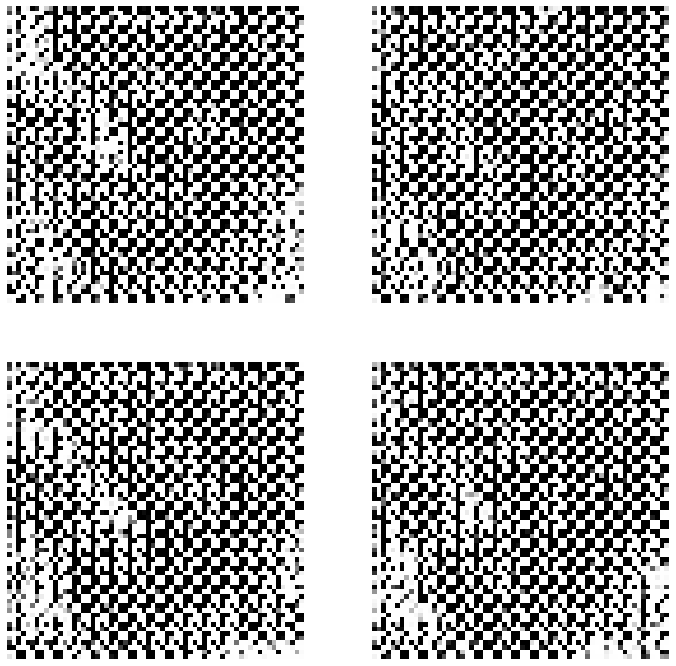

188/188 [==============================] - 329s 2s/step - d_loss: 0.7839 - g_loss: 0.4718
Epoch 2/20
188/188 [==============================] - ETA: 0s - d_loss: 0.6146 - g_loss: 0.4579

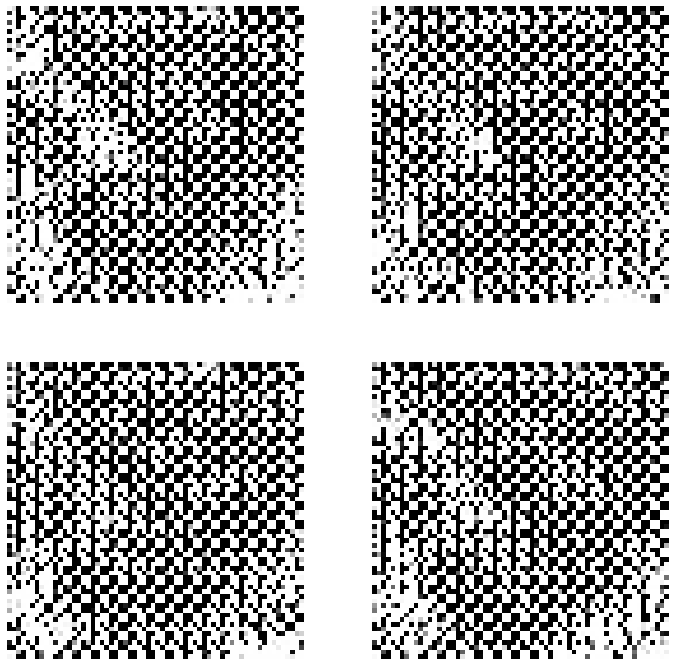

188/188 [==============================] - 328s 2s/step - d_loss: 0.6146 - g_loss: 0.4579
Epoch 3/20
188/188 [==============================] - ETA: 0s - d_loss: 0.2319 - g_loss: 0.7450

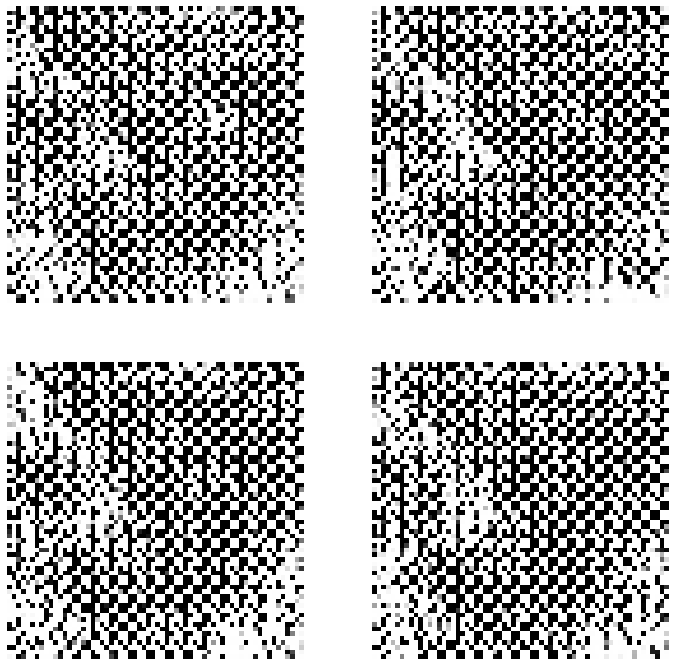

188/188 [==============================] - 329s 2s/step - d_loss: 0.2319 - g_loss: 0.7450
Epoch 4/20
188/188 [==============================] - ETA: 0s - d_loss: 0.1045 - g_loss: 0.9776

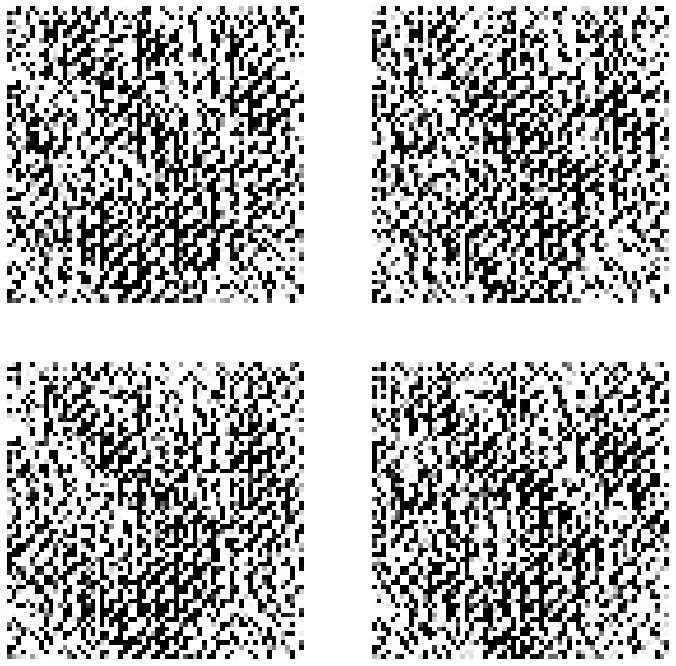

188/188 [==============================] - 328s 2s/step - d_loss: 0.1045 - g_loss: 0.9776
Epoch 5/20
188/188 [==============================] - ETA: 0s - d_loss: 0.5972 - g_loss: 0.6094

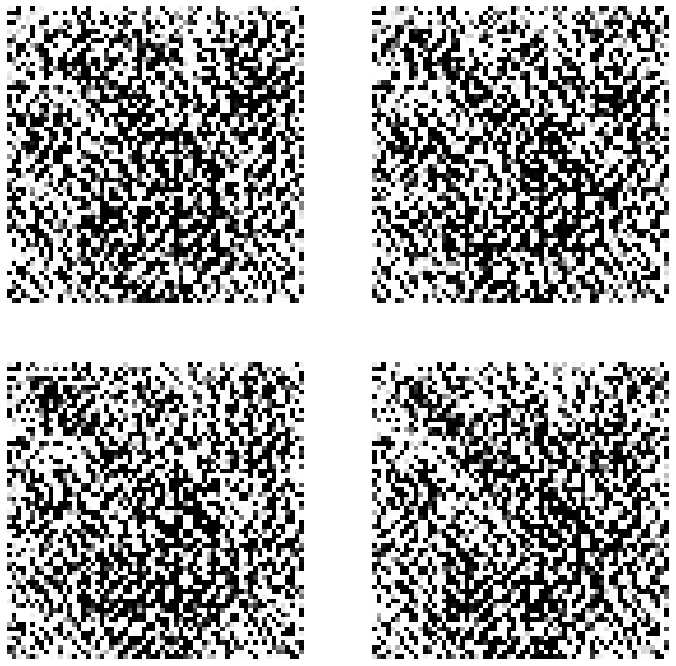

188/188 [==============================] - 328s 2s/step - d_loss: 0.5972 - g_loss: 0.6094
Epoch 6/20
188/188 [==============================] - ETA: 0s - d_loss: 0.5556 - g_loss: 0.7723

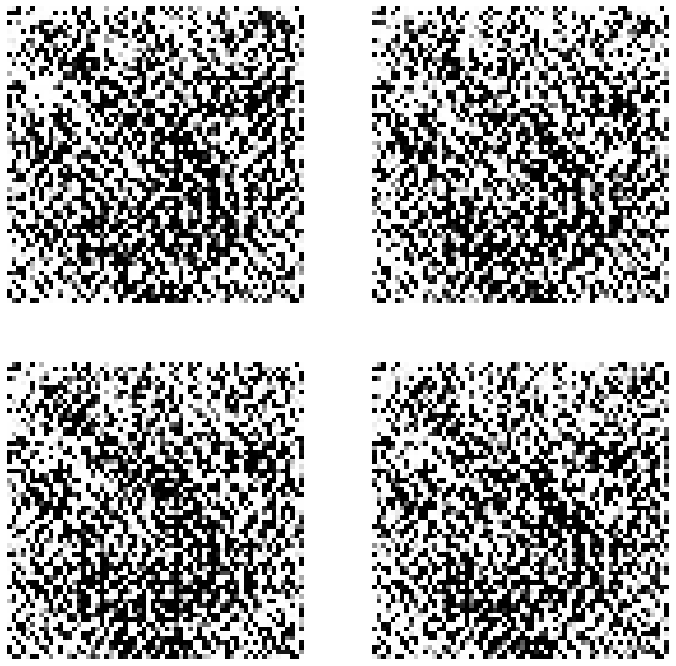

188/188 [==============================] - 328s 2s/step - d_loss: 0.5556 - g_loss: 0.7723
Epoch 7/20
188/188 [==============================] - ETA: 0s - d_loss: 0.3231 - g_loss: 1.1738

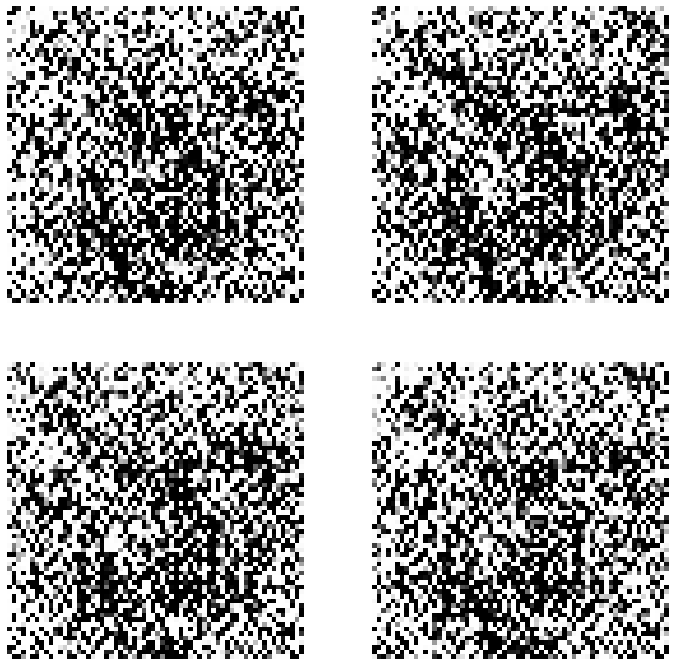

188/188 [==============================] - 331s 2s/step - d_loss: 0.3231 - g_loss: 1.1738
Epoch 8/20
188/188 [==============================] - ETA: 0s - d_loss: 0.1824 - g_loss: 1.5429

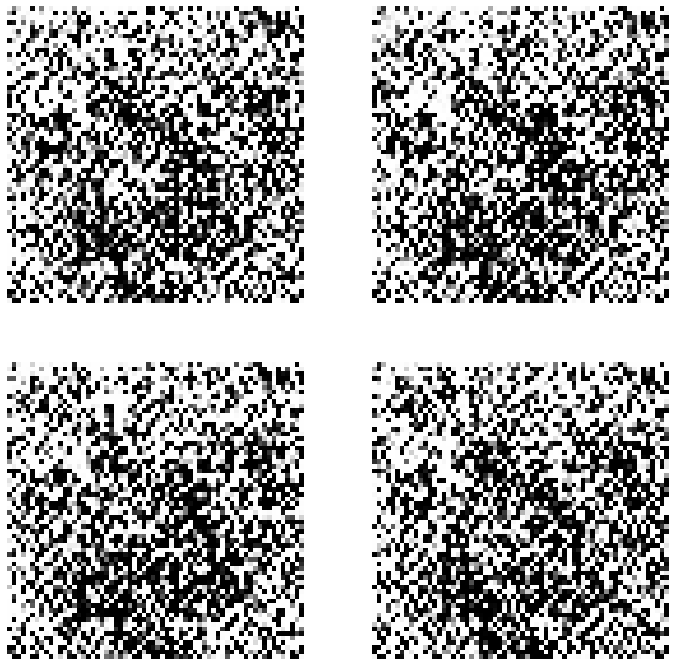

188/188 [==============================] - 331s 2s/step - d_loss: 0.1824 - g_loss: 1.5429
Epoch 9/20
188/188 [==============================] - ETA: 0s - d_loss: -0.0079 - g_loss: 2.0744

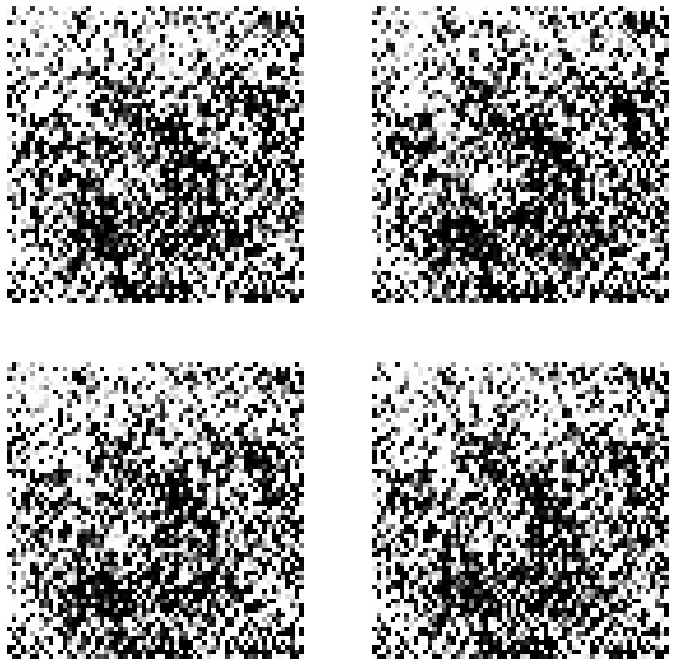

188/188 [==============================] - 334s 2s/step - d_loss: -0.0079 - g_loss: 2.0744
Epoch 10/20
188/188 [==============================] - ETA: 0s - d_loss: -0.0766 - g_loss: 2.4553

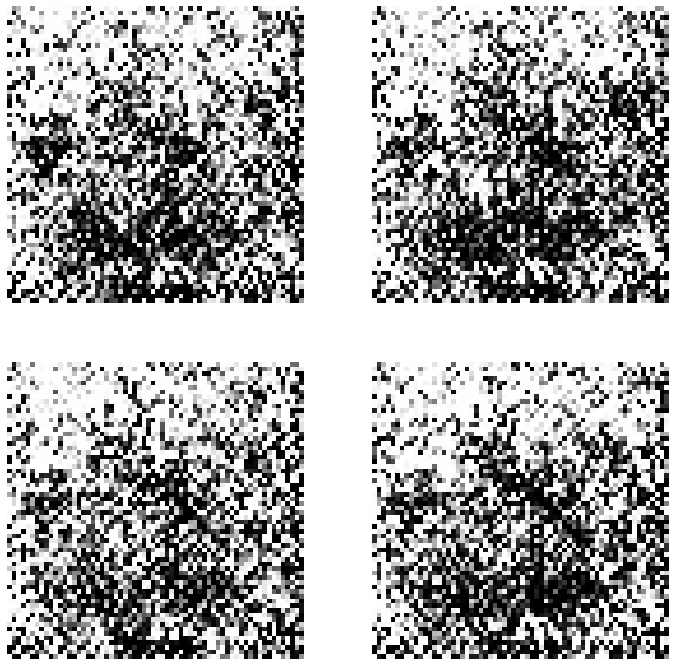

188/188 [==============================] - 328s 2s/step - d_loss: -0.0766 - g_loss: 2.4553
Epoch 11/20
188/188 [==============================] - ETA: 0s - d_loss: 0.2378 - g_loss: 2.0528

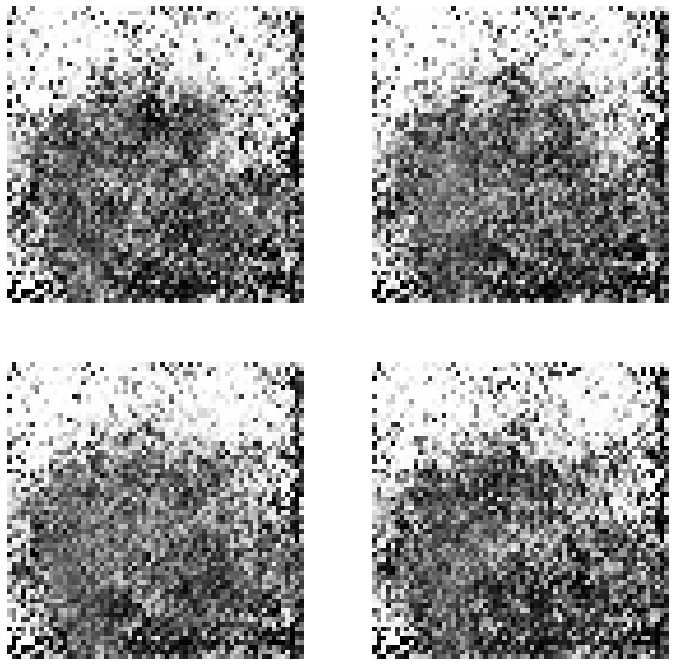

188/188 [==============================] - 330s 2s/step - d_loss: 0.2378 - g_loss: 2.0528
Epoch 12/20
188/188 [==============================] - ETA: 0s - d_loss: 0.5670 - g_loss: 1.6239

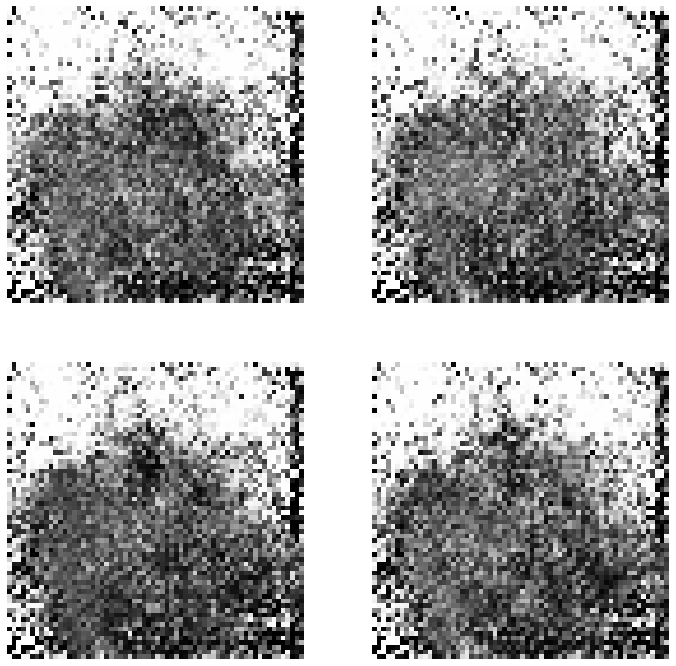

188/188 [==============================] - 327s 2s/step - d_loss: 0.5670 - g_loss: 1.6239
Epoch 13/20
188/188 [==============================] - ETA: 0s - d_loss: 0.5996 - g_loss: 1.7155

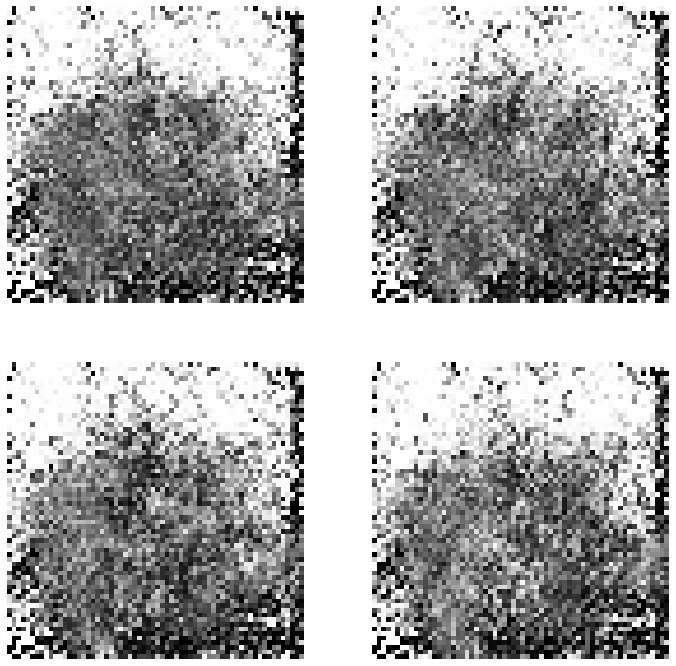

188/188 [==============================] - 328s 2s/step - d_loss: 0.5996 - g_loss: 1.7155
Epoch 14/20
188/188 [==============================] - ETA: 0s - d_loss: 0.5951 - g_loss: 1.8299

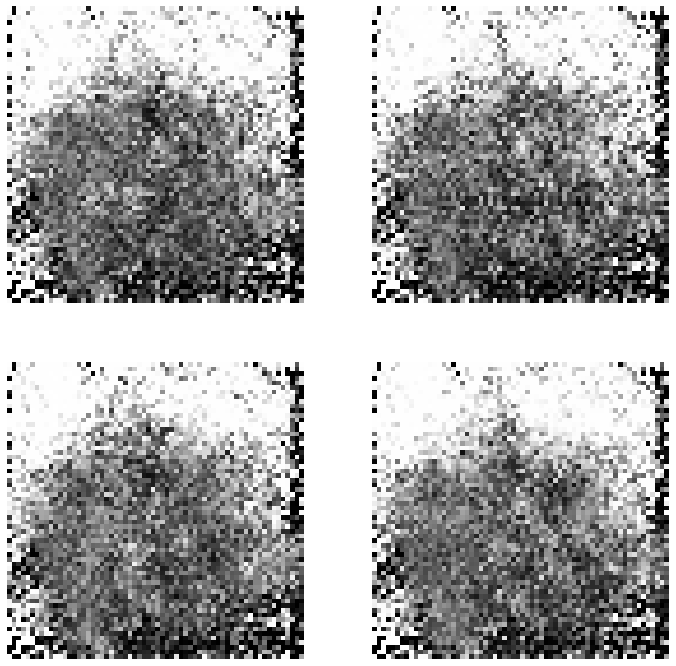

188/188 [==============================] - 328s 2s/step - d_loss: 0.5951 - g_loss: 1.8299
Epoch 15/20
188/188 [==============================] - ETA: 0s - d_loss: 0.5871 - g_loss: 1.9289

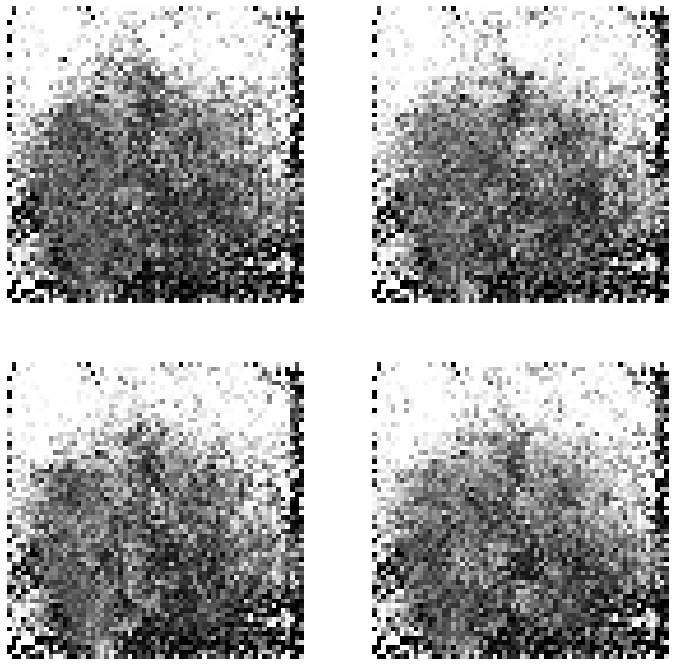

188/188 [==============================] - 329s 2s/step - d_loss: 0.5871 - g_loss: 1.9289
Epoch 16/20
188/188 [==============================] - ETA: 0s - d_loss: 0.5793 - g_loss: 2.0193

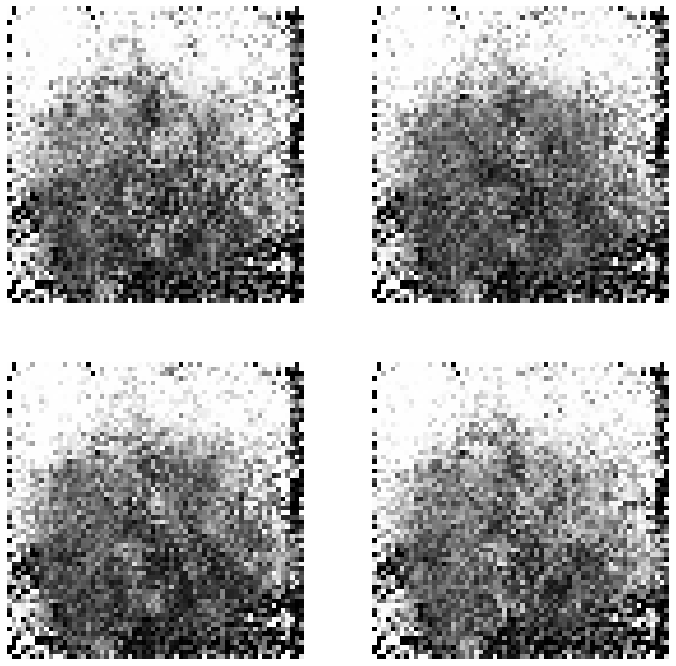

188/188 [==============================] - 326s 2s/step - d_loss: 0.5793 - g_loss: 2.0193
Epoch 17/20
188/188 [==============================] - ETA: 0s - d_loss: 0.5651 - g_loss: 2.1030

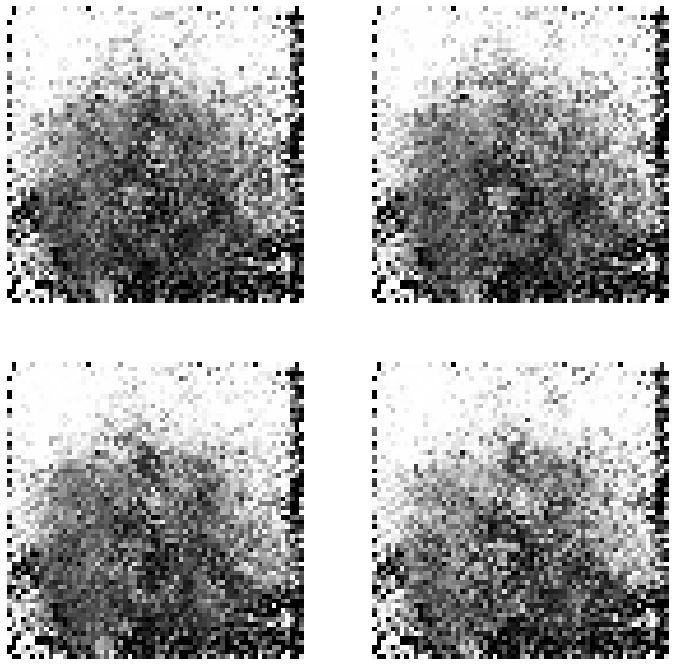

188/188 [==============================] - 326s 2s/step - d_loss: 0.5651 - g_loss: 2.1030
Epoch 18/20
188/188 [==============================] - ETA: 0s - d_loss: 0.5509 - g_loss: 2.1833

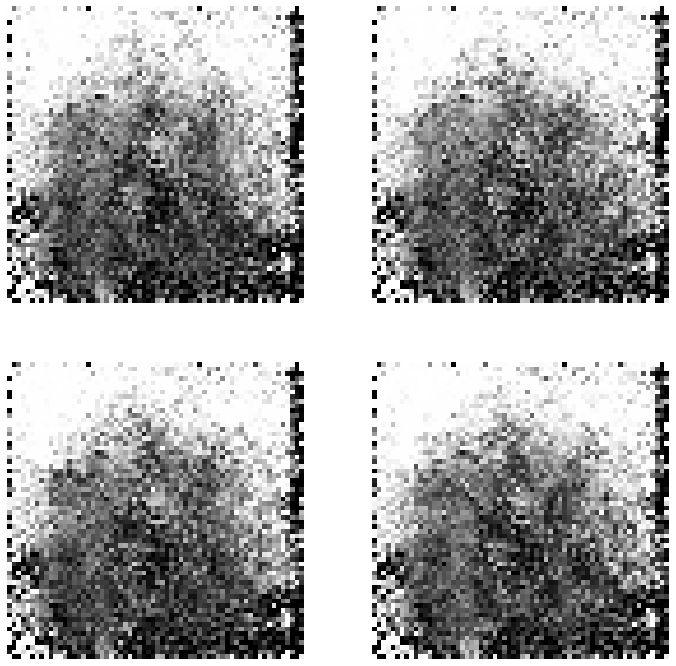

188/188 [==============================] - 331s 2s/step - d_loss: 0.5509 - g_loss: 2.1833
Epoch 19/20
188/188 [==============================] - ETA: 0s - d_loss: 0.5363 - g_loss: 2.2559

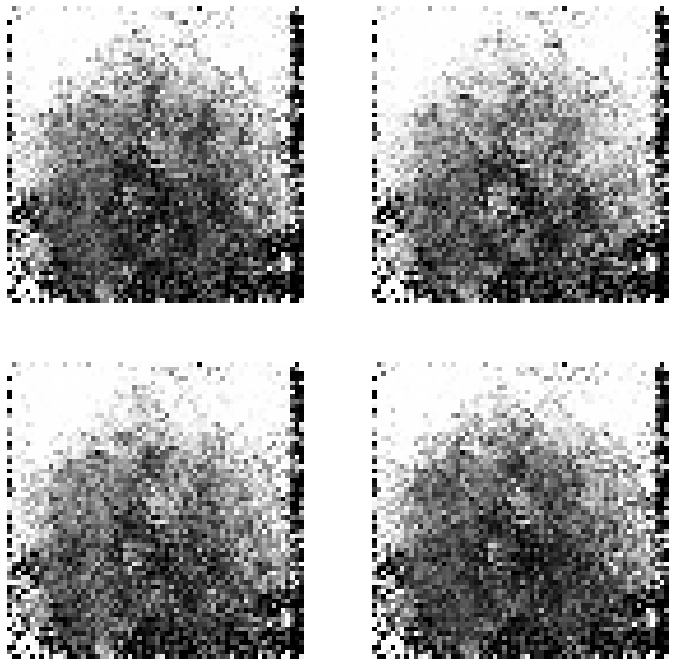

188/188 [==============================] - 332s 2s/step - d_loss: 0.5363 - g_loss: 2.2559
Epoch 20/20
188/188 [==============================] - ETA: 0s - d_loss: 0.5214 - g_loss: 2.3213

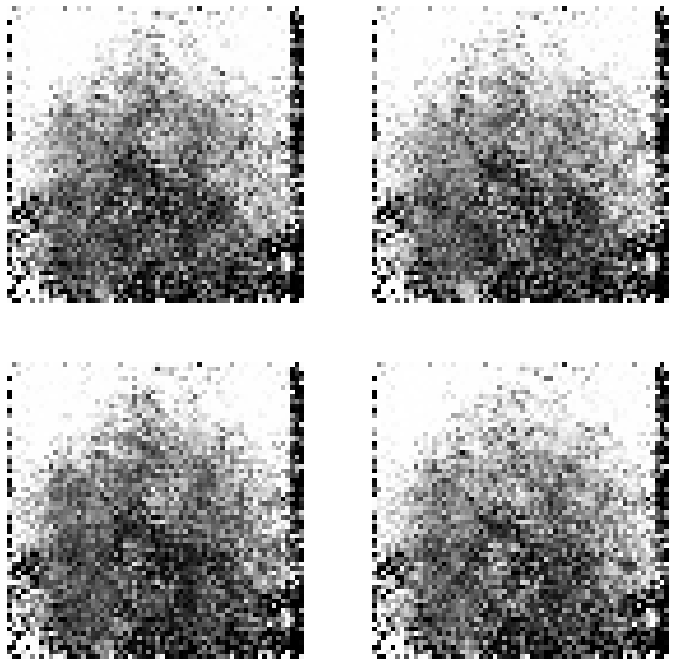

188/188 [==============================] - 335s 2s/step - d_loss: 0.5214 - g_loss: 2.3213


In [206]:


gan.fit(
    dataset,
    epochs=epochs,
    callbacks=[GANMonitor(num_img=4, latent_dim=latent_dim, show_every=1, save=True)],

)


# Discriminator and generator with diffrent learning rates

In [162]:
tf.keras.backend.clear_session()

In [163]:
del generator, gan

In [143]:
def build_generator(latent_dim=128):
    return tf.keras.Sequential(
        [
            tf.keras.Input(shape=(latent_dim,)),
            tf.keras.layers.Dense(8 * 8 * 128),
            tf.keras.layers.Reshape((8, 8, 128)),
            tf.keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
            AddGaussianNoise(stddev=0.1),  # Add Gaussian noise to the output of the first layer
            tf.keras.layers.LeakyReLU(alpha=0.2),
            AddGaussianNoise(stddev=0.1),
            tf.keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            AddGaussianNoise(stddev=0.1),
            tf.keras.layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            AddGaussianNoise(stddev=0.1),
            tf.keras.layers.Conv2D(1, kernel_size=5, padding="same", activation="tanh"),
        ],
        name="generator",
    )
generator = build_generator()

In [144]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128, show_every=1, save=True):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save = save
        self.show_every = show_every

    def on_epoch_end(self, epoch, logs=None):

        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images + 1) * 127.5  # Adjust scaling for image format
        generated_images.numpy()

        if self.save:
            for i in range(self.num_img):
                img = tf.keras.utils.array_to_img(generated_images[i])
                img.save(f'generated-grayscale-new-2/generated_img_{epoch:03d}_{i}.png')

        if epoch % self.show_every != 0:
            return
        
        _, axs = plt.subplots(2,2, figsize=(12,12)) # https://stackoverflow.com/a/54681765
        axs = axs.flatten()
        for i, (img, ax) in enumerate(zip(generated_images, axs)):
            img = tf.keras.utils.array_to_img(img)
            ax.axis('off')
            ax.imshow(img, cmap='gray')
        plt.show()
        


In [145]:
epochs = 20 
latent_dim = 128

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

gan.compile(
    d_optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), 
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

In [146]:
reload = False # True to reload
generator_path = "generator_fingerptint_gan_2.h5"
discriminator_path = "discriminator_fingerptint_gan_2.h5"
if os.path.isfile(discriminator_path) and os.path.isfile(generator_path) and reload:
    gan.generator.load_weights(generator_path)
    gan.discriminator.load_weights(discriminator_path)

Epoch 1/20
188/188 [==============================] - ETA: 0s - d_loss: 0.4783 - g_loss: 1.3368

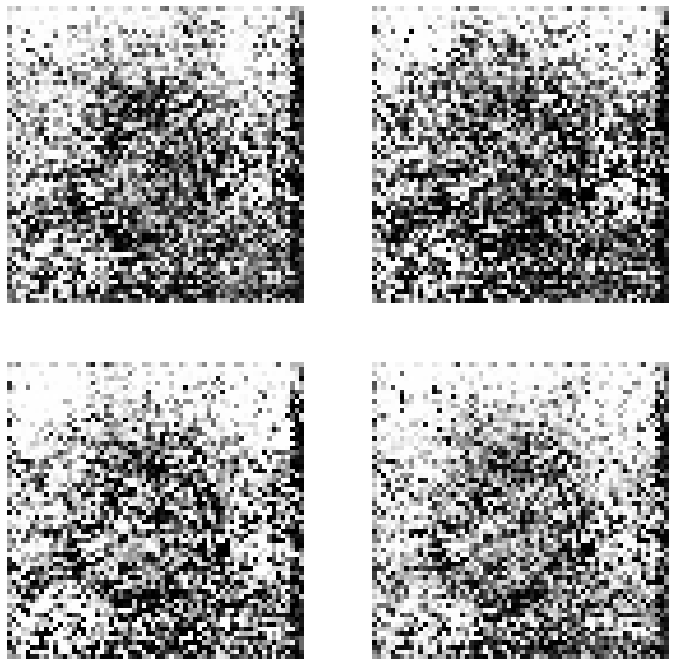

188/188 [==============================] - 311s 2s/step - d_loss: 0.4783 - g_loss: 1.3368
Epoch 2/20
188/188 [==============================] - ETA: 0s - d_loss: 0.6481 - g_loss: 1.3690

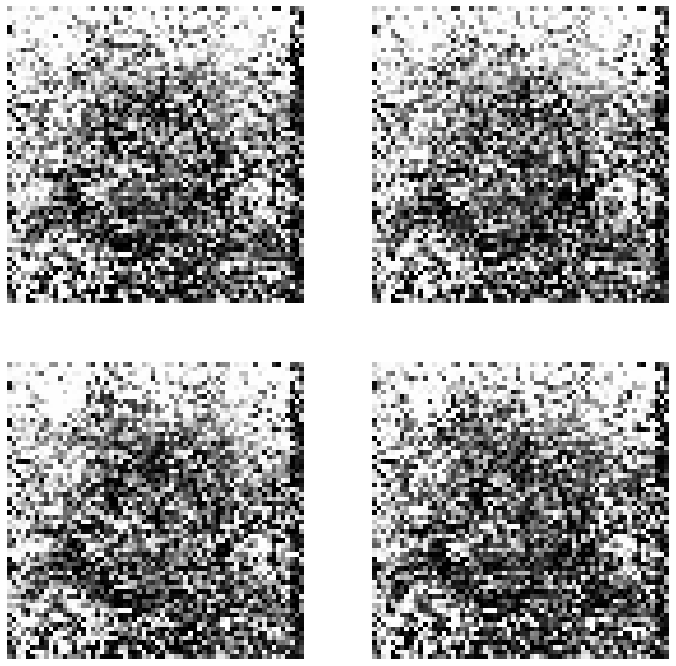

188/188 [==============================] - 306s 2s/step - d_loss: 0.6481 - g_loss: 1.3690
Epoch 3/20
188/188 [==============================] - ETA: 0s - d_loss: 0.6050 - g_loss: 1.6937

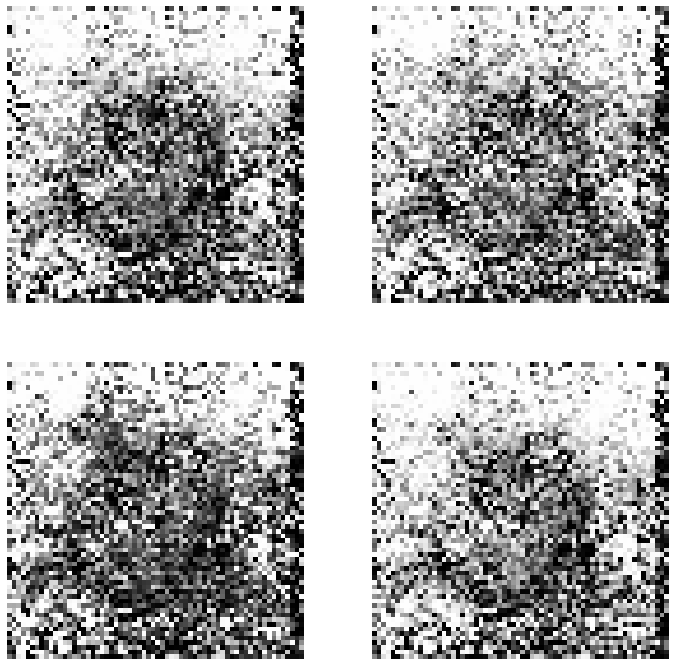

188/188 [==============================] - 305s 2s/step - d_loss: 0.6050 - g_loss: 1.6937
Epoch 4/20
188/188 [==============================] - ETA: 0s - d_loss: 0.5838 - g_loss: 1.9244

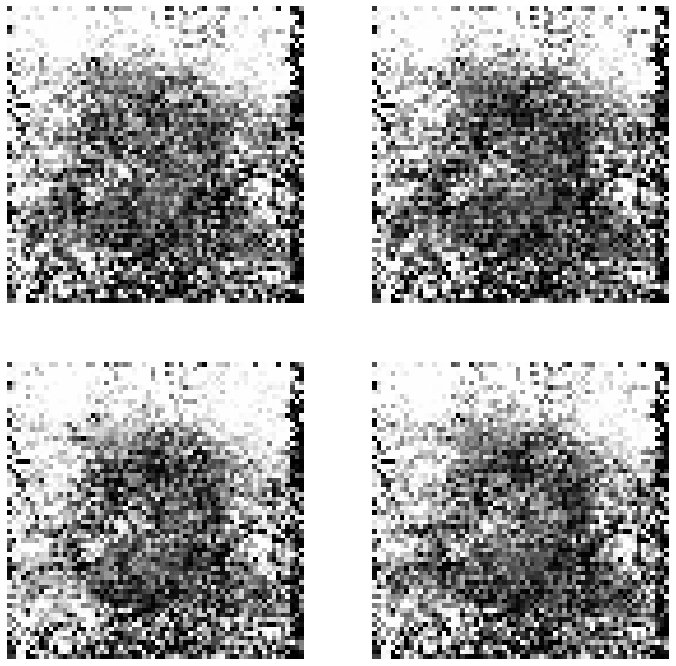

188/188 [==============================] - 303s 2s/step - d_loss: 0.5838 - g_loss: 1.9244
Epoch 5/20
188/188 [==============================] - ETA: 0s - d_loss: 0.5840 - g_loss: 2.0652

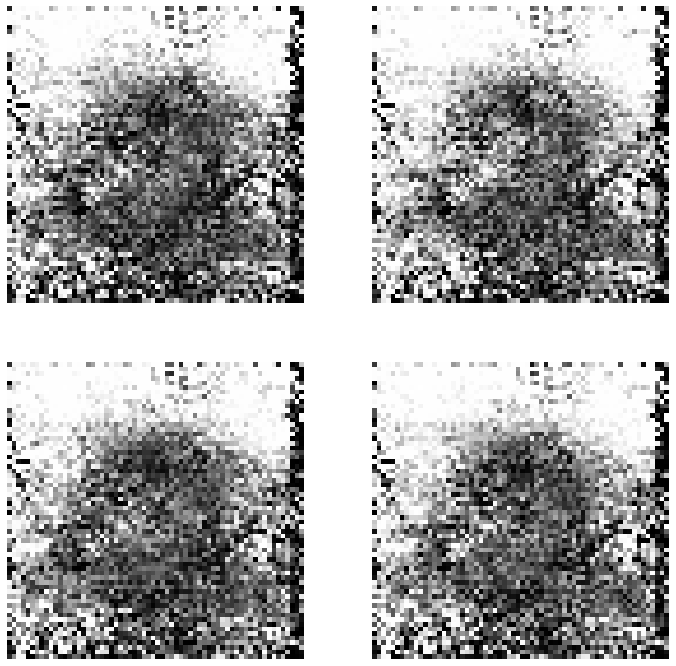

188/188 [==============================] - 305s 2s/step - d_loss: 0.5840 - g_loss: 2.0652
Epoch 6/20
188/188 [==============================] - ETA: 0s - d_loss: 0.5802 - g_loss: 2.1774

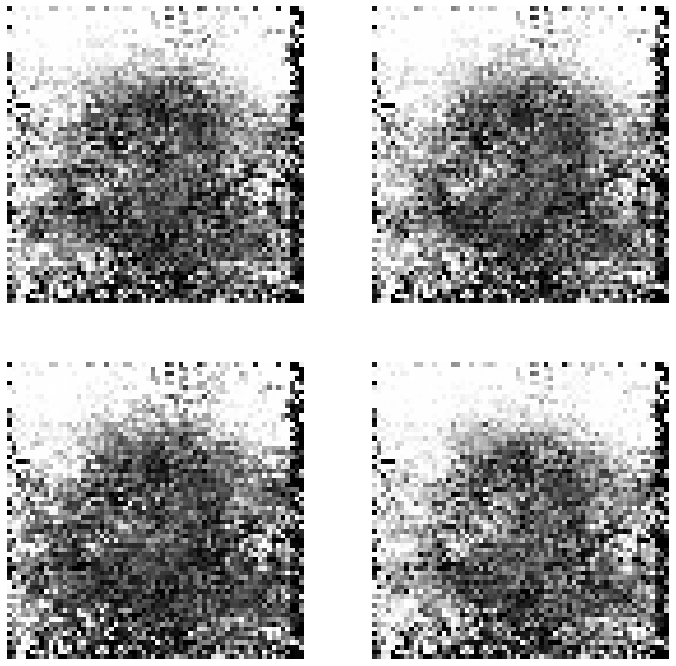

188/188 [==============================] - 304s 2s/step - d_loss: 0.5802 - g_loss: 2.1774
Epoch 7/20
188/188 [==============================] - ETA: 0s - d_loss: 0.5670 - g_loss: 2.2543

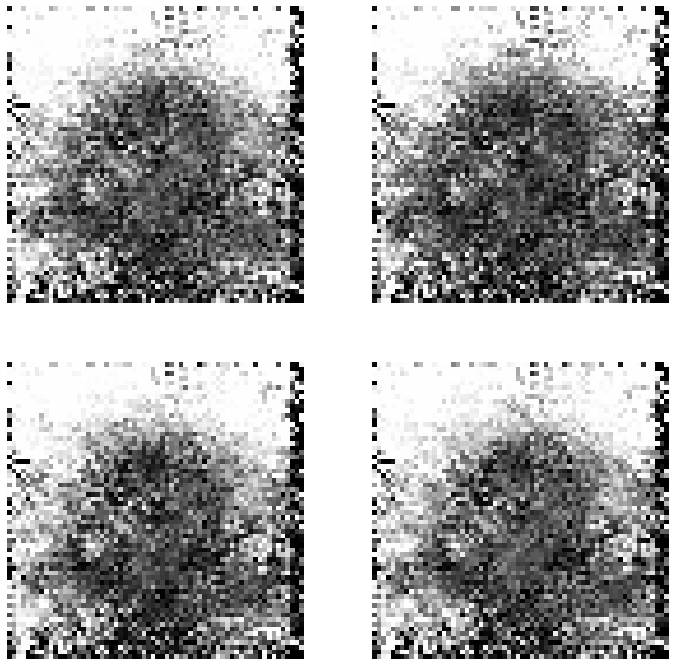

188/188 [==============================] - 303s 2s/step - d_loss: 0.5670 - g_loss: 2.2543
Epoch 8/20
188/188 [==============================] - ETA: 0s - d_loss: 0.5573 - g_loss: 2.2998

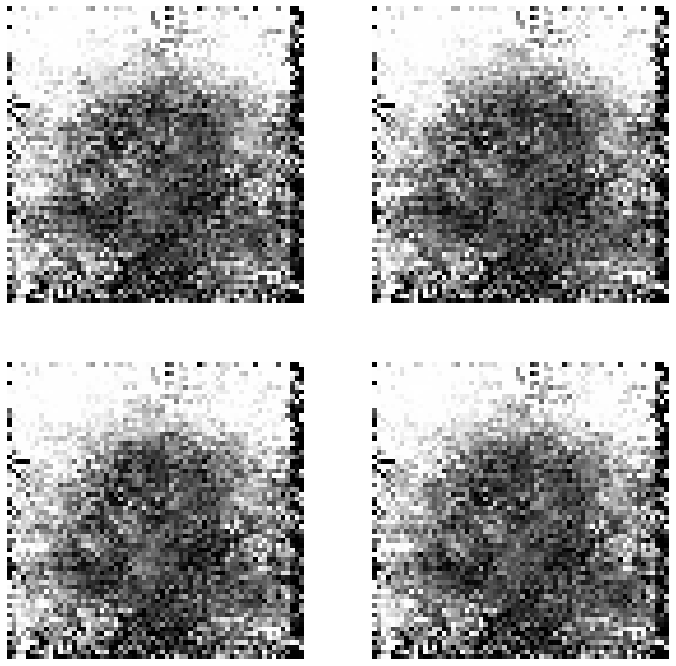

188/188 [==============================] - 305s 2s/step - d_loss: 0.5573 - g_loss: 2.2998
Epoch 9/20
188/188 [==============================] - ETA: 0s - d_loss: 0.5402 - g_loss: 2.3475

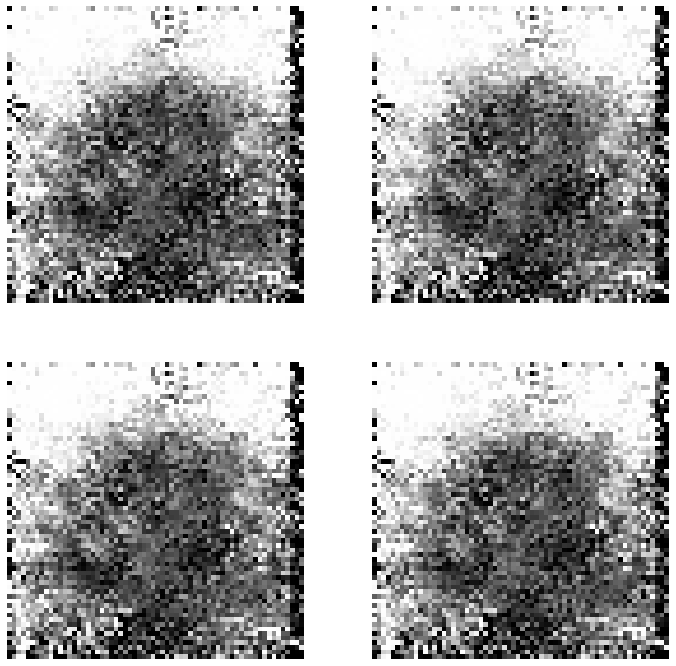

188/188 [==============================] - 304s 2s/step - d_loss: 0.5402 - g_loss: 2.3475
Epoch 10/20
188/188 [==============================] - ETA: 0s - d_loss: 0.5245 - g_loss: 2.3914

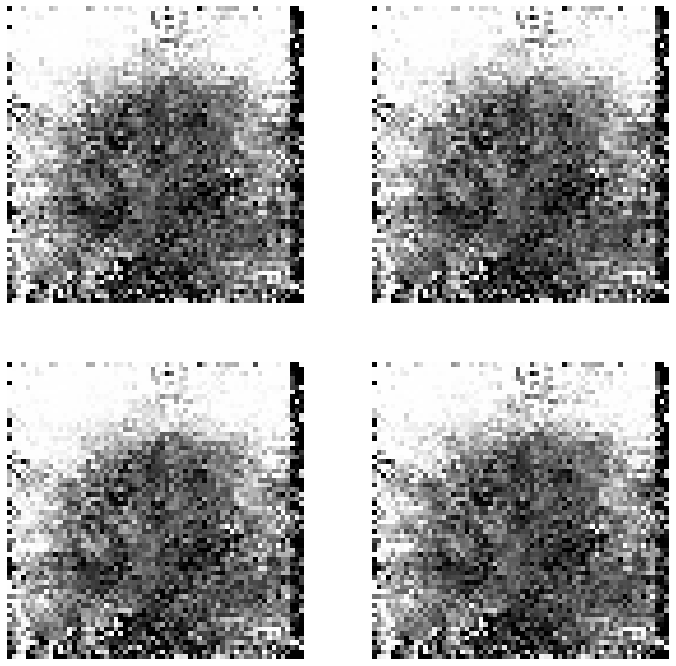

188/188 [==============================] - 305s 2s/step - d_loss: 0.5245 - g_loss: 2.3914
Epoch 11/20
188/188 [==============================] - ETA: 0s - d_loss: 0.5102 - g_loss: 2.4251

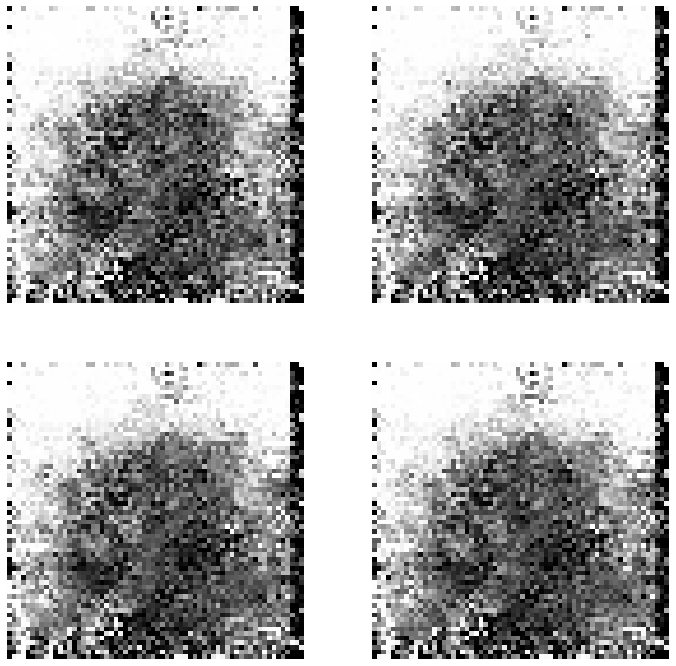

188/188 [==============================] - 308s 2s/step - d_loss: 0.5102 - g_loss: 2.4251
Epoch 12/20
188/188 [==============================] - ETA: 0s - d_loss: 0.4945 - g_loss: 2.4622

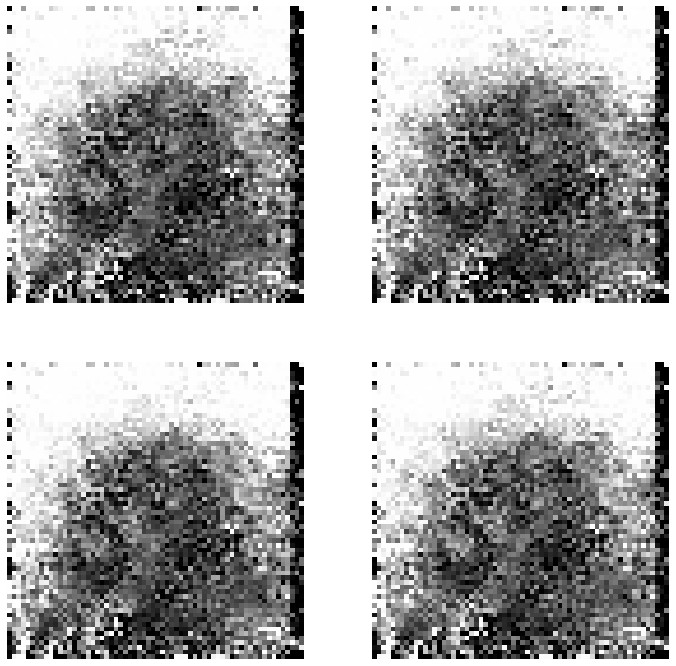

188/188 [==============================] - 310s 2s/step - d_loss: 0.4945 - g_loss: 2.4622
Epoch 13/20
188/188 [==============================] - ETA: 0s - d_loss: 0.4812 - g_loss: 2.4939

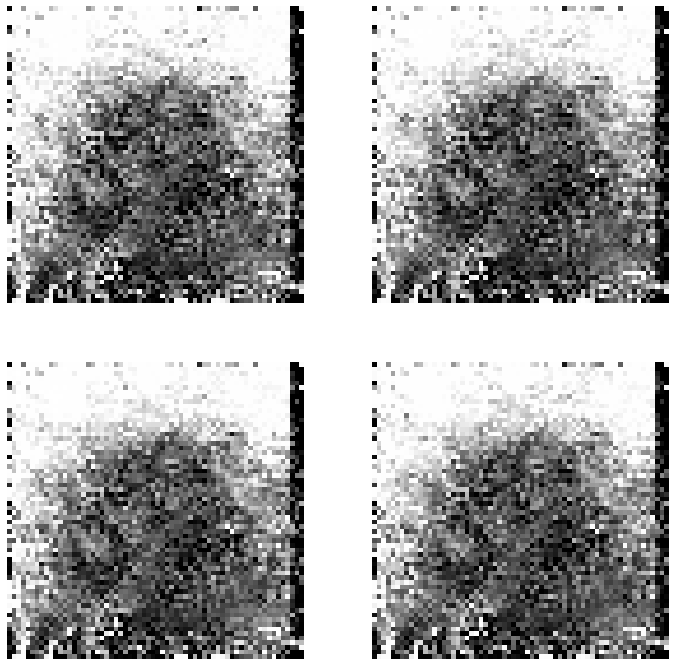

188/188 [==============================] - 310s 2s/step - d_loss: 0.4812 - g_loss: 2.4939
Epoch 14/20
188/188 [==============================] - ETA: 0s - d_loss: 0.4676 - g_loss: 2.5257

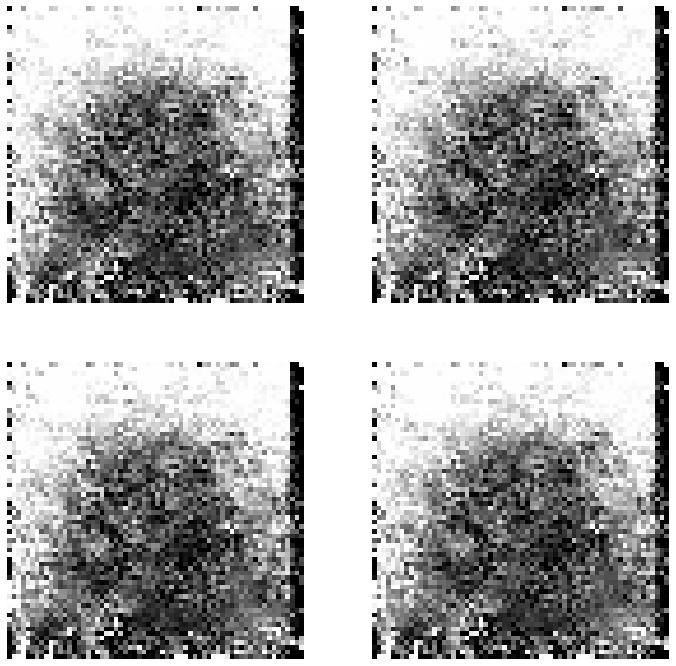

188/188 [==============================] - 305s 2s/step - d_loss: 0.4676 - g_loss: 2.5257
Epoch 15/20
188/188 [==============================] - ETA: 0s - d_loss: 0.4534 - g_loss: 2.5622

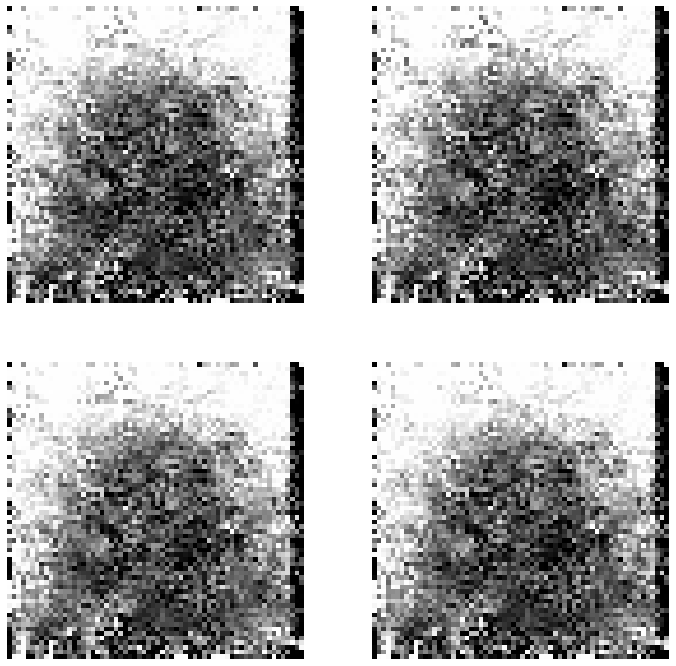

188/188 [==============================] - 302s 2s/step - d_loss: 0.4534 - g_loss: 2.5622
Epoch 16/20
188/188 [==============================] - ETA: 0s - d_loss: 0.4425 - g_loss: 2.5880

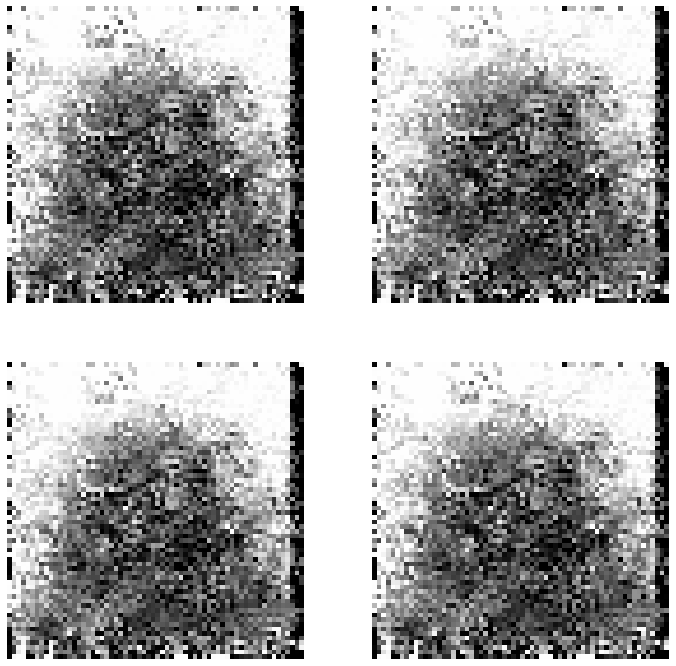

188/188 [==============================] - 303s 2s/step - d_loss: 0.4425 - g_loss: 2.5880
Epoch 17/20
188/188 [==============================] - ETA: 0s - d_loss: 0.4316 - g_loss: 2.6078

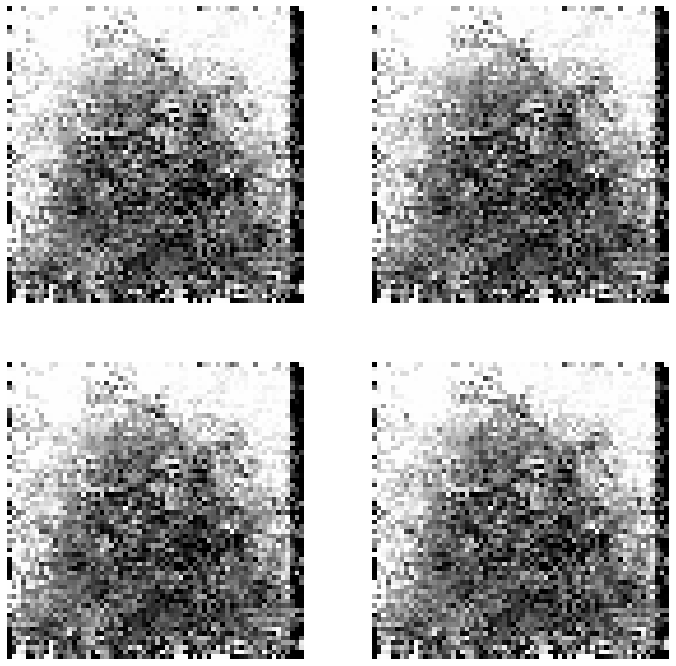

188/188 [==============================] - 303s 2s/step - d_loss: 0.4316 - g_loss: 2.6078
Epoch 18/20
188/188 [==============================] - ETA: 0s - d_loss: 0.4233 - g_loss: 2.6238

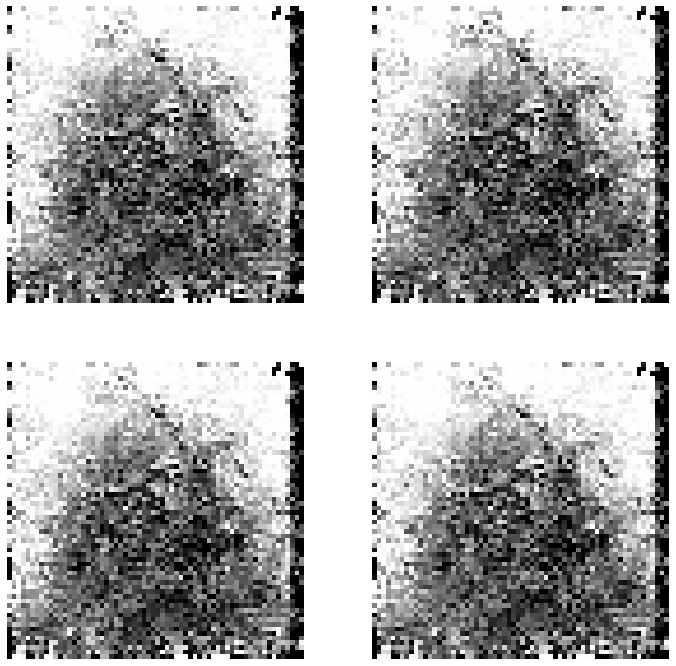

188/188 [==============================] - 304s 2s/step - d_loss: 0.4233 - g_loss: 2.6238
Epoch 19/20
188/188 [==============================] - ETA: 0s - d_loss: 0.4147 - g_loss: 2.6414

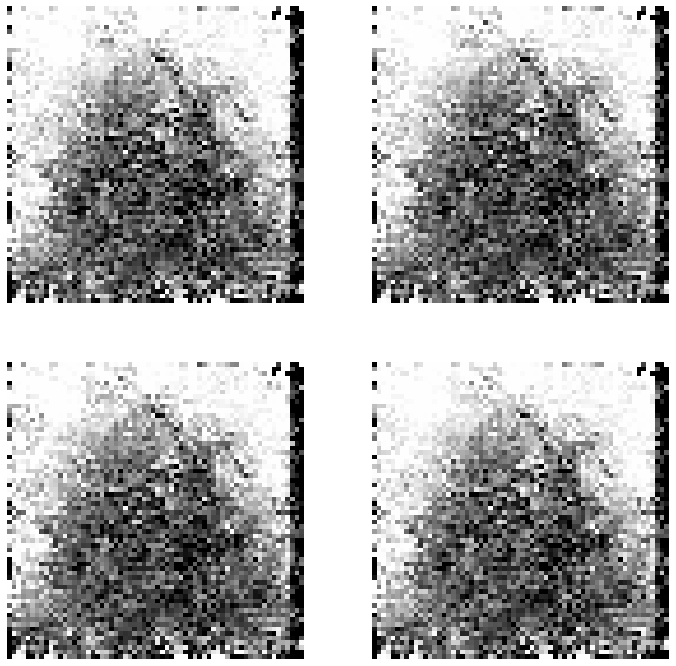

188/188 [==============================] - 304s 2s/step - d_loss: 0.4147 - g_loss: 2.6414
Epoch 20/20
188/188 [==============================] - ETA: 0s - d_loss: 0.4038 - g_loss: 2.6708

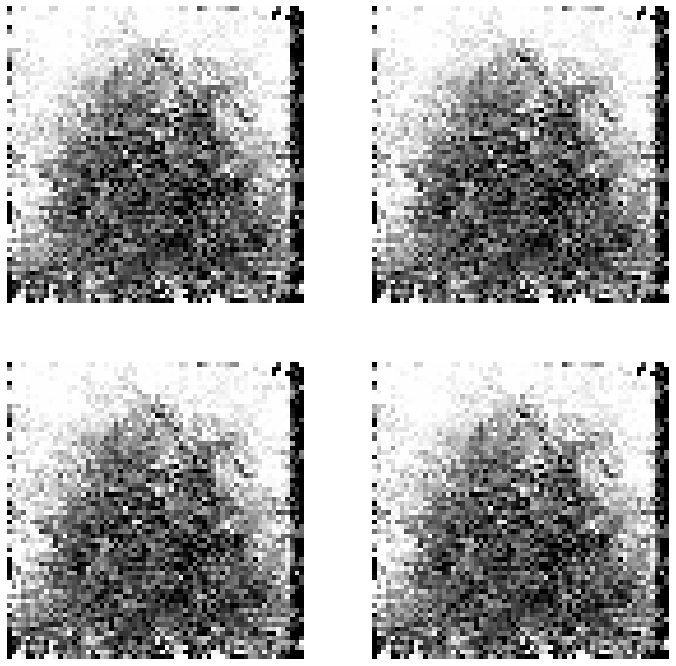

188/188 [==============================] - 303s 2s/step - d_loss: 0.4038 - g_loss: 2.6708


In [147]:

gan.fit(
    dataset,
    epochs=epochs,
    callbacks=[GANMonitor(num_img=4, latent_dim=latent_dim, show_every=1, save=True)],
    
)
